# Load Graphs 

In [1]:
import pickle
with open('mm-mm-weighted.pickle', 'rb') as f:
    mmlist = pickle.load(f)

In [2]:
import networkx as nx
G1=nx.Graph()
for i in range(len(mmlist)):
    if G1.has_node(mmlist[i][0])==False:
        G1.add_node(mmlist[i][0])
    if G1.has_node(mmlist[i][1])==False:
        G1.add_node(mmlist[i][1])
    G1.add_edge(mmlist[i][0],mmlist[i][1],weight=mmlist[i][2])
G1

In [3]:
G1.number_of_nodes()

623

In [4]:
G2=nx.Graph()
G2=G1
G2

In [5]:
print('len G1:', len(G1))

print('len G2:',len(G2))

len G1: 623
len G2: 623


# Swap graphs if len G1 > len G2

In [6]:
### Check and Swap if G1 > G2 ###
if len(G1)>len(G2):
    temp=G1
    G1=G2
    G2=temp
print(len(G1))
print(len(G2))

623
623


In [7]:
ed1=G1.edges()

In [8]:
nd1=G1.nodes()

In [9]:
ed2=G2.edges()

In [10]:
len(ed2)

1760

In [11]:
nd2=G2.nodes()

In [12]:
len(ed1)

1760

In [13]:
len(nd1)

623

In [14]:
el1=list(ed1)
el2=list(ed2)

In [15]:
nd1=list(nd1)
nd2=list(nd2)

In [16]:
degG1 = [val for (node, val) in G1.degree()]


In [17]:
degG2 = [val for (node, val) in G2.degree()]

# Define Target Graph

In [18]:
G_target_na=nx.read_weighted_edgelist('mm-mm.evals')
G_target_na 

In [19]:
gtnode=list(G_target_na.nodes())
print(len(gtnode))
g_t_node=[]
for i in range(len(gtnode)):
    if (G1.has_node(gtnode[i])==False and G2.has_node(gtnode[i])==False):
        continue
    else:
        g_t_node.append(gtnode[i])

#print(gtnode)
print(len(g_t_node))

24267
623


In [20]:
G_target=nx.Graph()
for i in range(len(g_t_node)):
    for j in range(len(g_t_node)):
        if G_target_na.has_node(g_t_node[i])==False:
            G_target.add_node(g_t_node[i])
        if G_target_na.has_node(g_t_node[j])==False:
            G_target.add_node(g_t_node[j])
        if G_target_na.has_edge(g_t_node[i],g_t_node[j]):
            a=list(G_target_na.get_edge_data(g_t_node[i],g_t_node[j]).values())
            #b=list(a[0][0].values())
            G_target.add_edge(g_t_node[i],g_t_node[j],weight=a[0])
G_target

In [22]:
G_target_na=G_target

In [21]:
len(G_target)

623

# Compute Score for create similarity matrix
برای ساخت هسته اولیه جهت تولید جمعیت بایدامتیاز اولیه و ماتریس شباهت را بسازیم. این امتیازات را بر اساس پیج رنک، میزان تفاوت درجات رئوس در دو گراف، ضریب یال ورودی، تفاوت بین ضرایب یال های دو گراف و خوشه بندی آنها و شباهت توالی (امتیاز بلست) می سازیم که برگرفته از مقاله می-الاین است 

In [23]:
def deg_Diff(G1,G2):
    Degree_Difference=np.zeros((len(G1),len(G2)))
    for i in range(len(G1)):
        for j in range(len(G2)):
            Degree_Difference[i][j]=abs(degG1[i]-degG2[j])/max(degG1[i],degG2[j])
    return Degree_Difference

In [24]:
def score_pageRank(X):
    a=nx.pagerank(X)
    return a

In [25]:
def coefficient_pagerank(x,y):  #x is G1, y is G2
   # print(len(x))
    p1=score_pageRank(x)
    b=p1.values()
    pr1=list(b)
    p2=score_pageRank(y)
    c=p2.values()
    pr2=list(c)
    pr=np.zeros((len(x),len(y)))
    for i in range(len(x)):
        for j in range(len(y)):
            #print(pr1[i],pr2[j])
            pr[i][j]=abs(pr1[i]-pr2[j])/max(pr1[i],pr2[j])   #minimum pr is maximum similarity of topology 
    return pr

In [26]:
def coefficient_edges(index_node, G, GraphNumber):
    if GraphNumber==1:
        sum_edge=0        
        for i in G.neighbors(nd1[index_node]):                       
            sum_edge=sum_edge+degG1[nd1.index(i)]
        #print(sum_edge)
        temp=(degG1[index_node]-1) if degG1[index_node]> 1 else 1        
        coeff_node=(2*sum_edge)/(degG1[index_node]*temp)
    else:
        sum_edge=0        
        for i in G.neighbors(nd2[index_node]):                       
            sum_edge=sum_edge+degG2[nd2.index(i)]
        #print(sum_edge)
        temp=(degG2[index_node]-1) if degG2[index_node]> 1 else 1        
        coeff_node=(2*sum_edge)/(degG2[index_node]*temp)
    return coeff_node
    

In [27]:
def compute_Ea(G1,G2):
    Ea_G1=np.zeros(len(G1))
    Ea_G2=np.zeros(len(G2))
    for i in range(len(G1)):
        Ea_G1[i]=coefficient_edges(i, G1, 1)
    for j in range(len(G2)):
        Ea_G2[j]=coefficient_edges(j,G2,2)
    ea=[Ea_G1, Ea_G2]
    return(ea)

In [28]:
# compute relative clustering coefficient difference between node a (in G1) and node b (in G2)
def CD(G1, G2):
    cd=np.zeros((len(G1),len(G2)))
    EA=compute_Ea(G1,G2)
    #print(EA[0])      #Ea for G1
    #print("===================")
    #print(EA[1])      #Ea for G2
    for i in range(len(G1)):
        for j in range(len(G2)):
            cd[i,j]=abs(EA[0][i]-EA[1][j])/max(EA[0][i],EA[1][j])
    return cd

In [29]:
def sequence_score(x,y):
    seq=np.zeros((len(x),len(y)))
    for i in range(len(x)):
        for j in range(len(y)):
            q1=G_target_na.get_edge_data(str(nd1[i]),str(nd2[j]))
            if q1==None:
                c=0
            else:
                c=list(q1.values())
                c=c[0]
            seq[i][j]=c    
            
    return seq

In [30]:
def compute_score(G1,G2):
    coeff_pr=coefficient_pagerank(G1,G2)
    dd=deg_Diff(G1,G2)
    cd=CD(G1,G2)
    seq_sc=sequence_score(G1,G2)
    
    alpha=0.1
    betta=0.2
    gamma=0.2
    zetta=1-alpha-betta-gamma
    s=alpha*(1-coeff_pr)+betta*(1-dd)+gamma*(1-cd)+zetta*seq_sc
    return s

In [31]:
import numpy as np
m=compute_score(G1,G2)
n=m


# multi tasking for initial population

In [32]:
def task1(len_G1, similarity_score_matrix,m,index_score,pop,rand_permutation):
    print('task1')
    for z1 in range(int(len_G1/3)):
        for z2 in range(len_G1):
            similarity_score_matrix[z1][z2]=m[z1][int(rand_permutation[z1][z2])]
        index_score=np.argmax(similarity_score_matrix,axis=1)               
        pop[i][z1][0]=nd1.index(nd1[z1])
        pop[i][z1][1]=nd2.index(nd2[int(rand_permutation[z1][index_score[z1]])])
  

In [33]:
def task2(len_G1, similarity_score_matrix,m,index_score,pop,rand_permutation):
    print('task2')
    for z1 in range(int(len_G1/3),int(2*len_G1/3)):
        for z2 in range(len_G1):
            similarity_score_matrix[z1][z2]=m[z1][int(rand_permutation[z1][z2])]
        index_score=np.argmax(similarity_score_matrix,axis=1)               
        pop[i][z1][0]=nd1.index(nd1[z1])
        pop[i][z1][1]=nd2.index(nd2[int(rand_permutation[z1][index_score[z1]])])
    

In [34]:
def task3(len_G1, similarity_score_matrix,m,index_score,pop,rand_permutation):
    print('task3')
    for z1 in range(int(2*len_G1/3),len_G1):
        for z2 in range(len_G1):
            similarity_score_matrix[z1][z2]=m[z1][int(rand_permutation[z1][z2])]
        index_score=np.argmax(similarity_score_matrix,axis=1)               
        pop[i][z1][0]=nd1.index(nd1[z1])
        pop[i][z1][1]=nd2.index(nd2[int(rand_permutation[z1][index_score[z1]])])

# multi processing for speed up

In [35]:
def fun_rand_permute(len_G1, base_permute, rand_permutation):
    for k in range(len_G1):
        rand_permutation[k]=random.sample(base_permute,len_G1)
    #print(rand_permutation)

# Initialization such as MeAlign

In [36]:
#%%prun
import random
import threading

len_pop=300
len_G1=len(G1)
len_G2=len(G2)
similarity_score_matrix=np.zeros((len_G1,len_G1))
sim_score_matrix=np.zeros((len_G1,len_G1))
pop=np.zeros((len_pop,len_G1,2))
index_score=np.zeros(len_G1)
rand_permutation=np.zeros((len_G1,len_G1))
base_permute = [j for  j in range(0, len_G2)]

for i in range(len_pop):  
    print('wait')
    if i>0:
        do_not_permute = set(base_permute)-set(index_score)#[item for item in base_permute if item not in index_score]
        #print(do_not_permute)
        #print(len(base_permute))
        base_permute.extend(do_not_permute)
        #print(len(do_not_permute))
        #print(len(base_permute))
        #print(base_permute)
    t = threading.Thread(target=fun_rand_permute, args=(len_G1,base_permute, rand_permutation,))
    t.start() 
    t.join()
    #print(rand_permutation)
    
    """for k in range(len_G1):
        rand_permutation[k]=random.sample(base_permute,len_G1) """               
    print('in for loop')
    
    """for z1 in range(len_G1):
        for z2 in range(len_G1):
            similarity_score_matrix[z1][z2]=m[z1][int(rand_permutation[z1][z2])]
        index_score=np.argmax(similarity_score_matrix,axis=1)               
        pop[i][z1][0]=nd1.index(nd1[z1])
        pop[i][z1][1]=nd2.index(nd2[int(rand_permutation[z1][index_score[z1]])])"""
    
    t1 = threading.Thread(target=task1, args=(len_G1, similarity_score_matrix,m,index_score,pop,rand_permutation,)) 
    t2 = threading.Thread(target=task2, args=(len_G1, similarity_score_matrix,m,index_score,pop,rand_permutation,))
    t3 = threading.Thread(target=task3, args=(len_G1, similarity_score_matrix,m,index_score,pop,rand_permutation,))
    # starting thread 1 
    t1.start() 
    # starting thread 2 
    t2.start() 
    # starting thread 3 
    t3.start() 
    # wait until thread 1 is completely executed 
    t1.join() 
    # wait until thread 2 is completely executed 
    t2.join() 
    # wait until thread 3 is completely executed 
    t3.join()
    # both threads completely executed 
    print("Done!, i=",i) 
    
pop

wait
in for loop
task1
task2
task3
Done!, i= 0
wait
in for loop
task1
task2
task3
Done!, i= 1
wait
in for loop
task1
task2
task3
Done!, i= 2
wait
in for loop
task1
task2
task3
Done!, i= 3
wait
in for loop
task1
task2
task3
Done!, i= 4
wait
in for loop
task1
task2
task3
Done!, i= 5
wait
in for loop
task1
task2
task3
Done!, i= 6
wait
in for loop
task1
task2
task3
Done!, i= 7
wait
in for loop
task1
task2
task3
Done!, i= 8
wait
in for loop
task1
task2
task3
Done!, i= 9
wait
in for loop
task1
task2
task3
Done!, i= 10
wait
in for loop
task1
task2
task3
Done!, i= 11
wait
in for loop
task1
task2
task3
Done!, i= 12
wait
in for loop
task1
task2
task3
Done!, i= 13
wait
in for loop
task1
task2
task3
Done!, i= 14
wait
in for loop
task1
task2
task3
Done!, i= 15
wait
in for loop
task1
task2
task3
Done!, i= 16
wait
in for loop
task1
task2
task3
Done!, i= 17
wait
in for loop
task1
task2
task3
Done!, i= 18
wait
in for loop
task1
task2
task3
Done!, i= 19
wait
in for loop
task1
task2
task3
Done!, i= 20
wa

Done!, i= 169
wait
in for loop
task1
task2
task3
Done!, i= 170
wait
in for loop
task1
task2
task3
Done!, i= 171
wait
in for loop
task1
task2
task3
Done!, i= 172
wait
in for loop
task1
task2
task3
Done!, i= 173
wait
in for loop
task1
task2
task3
Done!, i= 174
wait
in for loop
task1
task2
task3
Done!, i= 175
wait
in for loop
task1
task2
task3
Done!, i= 176
wait
in for loop
task1
task2
task3
Done!, i= 177
wait
in for loop
task1
task2
task3
Done!, i= 178
wait
in for loop
task1
task2
task3
Done!, i= 179
wait
in for loop
task1
task2
task3
Done!, i= 180
wait
in for loop
task1
task2
task3
Done!, i= 181
wait
in for loop
task1
task2
task3
Done!, i= 182
wait
in for loop
task1
task2
task3
Done!, i= 183
wait
in for loop
task1
task2
task3
Done!, i= 184
wait
in for loop
task1
task2
task3
Done!, i= 185
wait
in for loop
task1
task2
task3
Done!, i= 186
wait
in for loop
task1
task2
task3
Done!, i= 187
wait
in for loop
task1
task2
task3
Done!, i= 188
wait
in for loop
task1
task2
task3
Done!, i= 189
wait
i

array([[[  0.,   0.],
        [  1.,   1.],
        [  2.,   2.],
        ...,
        [620., 620.],
        [621., 621.],
        [622., 622.]],

       [[  0., 469.],
        [  1.,   1.],
        [  2.,   2.],
        ...,
        [620., 620.],
        [621., 621.],
        [622., 622.]],

       [[  0., 495.],
        [  1., 596.],
        [  2.,   2.],
        ...,
        [620., 620.],
        [621., 621.],
        [622., 622.]],

       ...,

       [[  0., 110.],
        [  1.,   1.],
        [  2.,   2.],
        ...,
        [620., 620.],
        [621., 621.],
        [622., 622.]],

       [[  0., 288.],
        [  1., 171.],
        [  2., 389.],
        ...,
        [620., 620.],
        [621., 621.],
        [622., 622.]],

       [[  0., 530.],
        [  1., 411.],
        [  2.,   2.],
        ...,
        [620., 620.],
        [621., 550.],
        [622., 622.]]])

# save population

In [37]:
import pickle
with open('mm-mm-base_permute_SA-GA.pickle', 'wb') as f:
    pickle.dump(base_permute, f)

In [38]:
import pickle
with open('mm-mm-pop_SA-GA.pickle', 'wb') as f:
    pickle.dump(pop, f)

# load population

In [ ]:
import pickle
with open('mm-sc-base_permute.pickle', 'rb') as f:
    base_permute = pickle.load(f)

In [ ]:
with open('mm-sc-pop.pickle', 'rb') as f:
    pop = pickle.load(f)

# compute measure edge correctness, ics, nc and s3

In [39]:
# ec function
def ec_func(pop1,pop2):
    a=list(G1.neighbors(pop1));
    b=list(G2.neighbors(pop2));
    for i in range(len(a)):
        for j in range(len(b)):
           # print(pop1,a[i],G1.has_edge(pop1,a[i]))
           # print(pop2,b[j],G2.has_edge(pop2,b[j]))
           # print(G_target_na.has_edge(a[i],b[j]))
            if(G1.has_edge(pop1,a[i]) and G2.has_edge(pop2,b[j]) and G_target_na.has_edge(a[i],b[j])):
                return True
    return False 

In [40]:
def induced_function_for_initialpop(sub_pop):
    num_induced=0
    sub_g2=list(set([sub_pop[i][1] for i in range(len(G1))]))
    for i in range(len(sub_g2)):
        for j in range(i,len(sub_g2)):
            if G2.has_edge(nd2[int(sub_g2[i])], nd2[int(sub_g2[j])]):
                num_induced=num_induced+1
    return num_induced

In [41]:
len_pop=len(pop)
score_ec=np.zeros(len_pop)
score_ics=np.zeros(len_pop)
score_s3=np.zeros(len_pop)
score_nc=np.zeros(len_pop)
score_ncorectness=np.zeros(len_pop)
num_seq=np.zeros(len_pop)

p=pop 
len_G1=len(G1)
map_items=[] #np.zeros((len_pop,len_G1,2))


for i in range(len(p)):
    ea=0
    nc=0
    sub_pop=p[i]
    sub_g2=list(set([sub_pop[i][1] for i in range(len(G1))]))
    num_induced=induced_function_for_initialpop(sub_pop) 
    #print("number induced for i=",i," is: ",num_induced)
    
    for j in range(len_G1):                          
         if G_target_na.has_edge(nd1[int(p[i][j][0])],nd2[int(p[i][j][1])]):
            num_seq[i]+=1  # create sequence matrix 
            map_items.append([nd1[int(p[i][j][0])],nd2[int(p[i][j][1])]])
            if (ec_func(nd1[int(p[i][j][0])],nd2[int(p[i][j][1])])):
                ea=ea+1                
            #ec=ec+1
            nc=nc+2
                 
    score_ec[i]=(ea/G1.number_of_edges())*100
    score_ics[i]=(ea/num_induced)*100
    score_s3[i]=(ea/(G1.number_of_edges()+num_induced-ea))*100
    score_nc[i]=(nc/(G1.number_of_nodes()))*100 # node coverage    
    score_ncorectness[i]=(nc/G_target_na.number_of_nodes())*100

    """if (score_nc[i] > 100):
        score_nc[i]=100
    if (score_ncorectness[i] > 100):
        score_ncorectness[i]=100
    if (score_ec[i] > 100):
        score_ec[i]=100
    if (score_ics[i] > 100):
        score_ics[i]=100
    if (score_s3[i] > 100):
        score_s3[i]=100"""

print('ec')
print(score_ec)
print('ics')
print(score_ics)
print('s3')
print(score_s3)
print('node coverage: ',score_nc)
print('node correctness',score_ncorectness)

ec
[35.39772727 32.27272727 31.64772727 30.90909091 31.25       30.79545455
 30.11363636 30.         30.05681818 30.34090909 30.96590909 30.45454545
 29.88636364 30.39772727 29.71590909 30.45454545 29.65909091 30.625
 30.39772727 30.         29.54545455 30.90909091 30.11363636 29.65909091
 29.65909091 30.73863636 29.88636364 29.77272727 29.14772727 29.31818182
 29.26136364 29.94318182 29.03409091 29.31818182 29.65909091 30.625
 30.22727273 29.65909091 30.         30.51136364 30.11363636 30.68181818
 29.43181818 29.71590909 28.97727273 30.28409091 30.         29.43181818
 29.65909091 30.79545455 30.05681818 30.         29.94318182 30.11363636
 29.43181818 29.31818182 30.73863636 29.71590909 29.60227273 29.94318182
 30.68181818 29.77272727 31.13636364 29.65909091 30.11363636 30.34090909
 29.48863636 29.77272727 29.88636364 30.34090909 30.28409091 30.
 29.88636364 29.48863636 30.45454545 29.65909091 29.65909091 30.17045455
 29.54545455 29.375      29.54545455 30.05681818 30.05681818 30.17

## number of matched sequences 

In [42]:
num_seq

array([623., 568., 557., 544., 550., 542., 530., 528., 529., 534., 545.,
       536., 526., 535., 523., 536., 522., 539., 535., 528., 520., 544.,
       530., 522., 522., 541., 526., 524., 513., 516., 515., 527., 511.,
       516., 522., 539., 532., 522., 528., 537., 530., 540., 518., 523.,
       510., 533., 528., 518., 522., 542., 529., 528., 527., 530., 518.,
       516., 541., 523., 521., 527., 540., 524., 548., 522., 530., 534.,
       519., 524., 526., 534., 533., 528., 526., 519., 536., 522., 522.,
       531., 520., 517., 520., 529., 529., 531., 529., 523., 514., 532.,
       531., 514., 513., 523., 529., 513., 525., 520., 528., 535., 523.,
       521., 531., 521., 541., 532., 523., 536., 518., 525., 538., 537.,
       516., 533., 526., 512., 529., 519., 522., 527., 533., 525., 519.,
       523., 518., 518., 533., 526., 522., 525., 515., 510., 534., 531.,
       530., 516., 530., 518., 542., 529., 526., 521., 518., 522., 520.,
       517., 519., 521., 520., 518., 520., 520., 52

## compute topology score

In [43]:
#compute Final Score
tscore=np.zeros(len_pop)
for i in range(len(p)):
    tscore[i]=(0.25*(score_ec[i]/G1.number_of_edges())+0.25*(score_s3[i]/(G1.number_of_edges()+score_ics[i]-score_ec[i]))+0.25*(score_ics[i]/2*G1.number_of_edges())+0.25*(score_nc[i]/(G1.number_of_nodes()+G2.number_of_nodes())))
print(tscore)

[ 7787.54821119  9777.82219178 10135.69292318  9990.02591077
  9401.75237547 10404.92907385  9915.00750469 10390.02354214
 10024.15859751  9839.23779445 10499.16709962 10070.0676212
 10019.08884468 11041.31785562 10075.34748258 10253.95507194
  9790.32221538 10939.15674505 10462.26420285  9451.62795175
  9361.74279661 10801.48676469  9906.58357314 11225.84752748
 10574.62662864 10422.10898722 10491.4284168  10947.80947705
  9891.36360827 11064.36807712 10017.723845   10314.98796311
 10100.66901314 10310.66719863 10613.71937179  9881.70887161
 10708.18450912 10906.02394203 11277.71144966 10345.05087491
 10264.12607497 10929.20526331  9560.44322951 10227.59657933
  9756.56169746 11000.04189831 10207.42277685  9841.1459393
  9977.45185907 10306.00619698 10484.72620589 10371.47000012
 10398.24763331 10485.65310922  9138.77344094 10236.28935856
 10532.78581569 10273.25531574 10316.872565   10206.02724433
 10959.45202795 10265.40174712 10547.72453421 10355.31598663
 10876.90732214 10689.7598

# Compute Topology and Sequence score

In [44]:
# Final Score
score=np.zeros(len_pop)
alpha=0.5
for i in range (len(p)):
    score[i]=alpha*tscore[i]+(1-alpha)*num_seq[i]   
score

array([4205.27410559, 5172.91109589, 5346.34646159, 5267.01295538,
       4975.87618773, 5473.46453692, 5222.50375234, 5459.01177107,
       5276.57929875, 5186.61889723, 5522.08354981, 5303.0338106 ,
       5272.54442234, 5788.15892781, 5299.17374129, 5394.97753597,
       5156.16110769, 5739.07837253, 5498.63210143, 4989.81397588,
       4940.87139831, 5672.74338235, 5218.29178657, 5873.92376374,
       5548.31331432, 5481.55449361, 5508.7142084 , 5735.90473852,
       5202.18180414, 5790.18403856, 5266.3619225 , 5420.99398156,
       5305.83450657, 5413.33359932, 5567.8596859 , 5210.3544358 ,
       5620.09225456, 5714.01197102, 5902.85572483, 5441.02543745,
       5397.06303748, 5734.60263165, 5039.22161475, 5375.29828967,
       5133.28084873, 5766.52094915, 5367.71138842, 5179.57296965,
       5249.72592953, 5424.00309849, 5506.86310294, 5449.73500006,
       5462.62381665, 5507.82655461, 4828.38672047, 5376.14467928,
       5536.89290784, 5398.12765787, 5418.9362825 , 5366.51362

## Define function for fitness and compute final score

In [45]:
def induced_function_for_pop(wpop):
    counter_induced=0
    subg=list(set([wpop[i][1] for i in range(len_G1)]))
    for i in range(len(subg)):
        for j in range(i,len(subg)):
            if G2.has_edge(nd2[int(subg[i])], nd2[int(subg[j])]):
                counter_induced=counter_induced+1
    #print("con: ",counter_induced)
    return counter_induced

In [46]:
def Fitness(wpop,counter_induced):
    ec_temp=0
    nc_temp=0
    num_seq_temp=0
    score_ncorectness=0
    
  
    for j in range(len_G1):        
        x1=int(wpop[j][0])
        x2=int(wpop[j][1])
        if G_target_na.has_edge(nd1[x1],nd2[x2]):
            num_seq_temp+=1 
            if (ec_func(nd1[x1],nd2[x2])):
                ec_temp=ec_temp+1                
            nc_temp=nc_temp+2
                 
    score_ec_temp=(ec_temp/G1.number_of_edges())*100
    score_ics_temp=(ec_temp/counter_induced)*100
    score_s3_temp=(ec_temp/(G1.number_of_edges()+counter_induced-ec_temp))*100
    score_nc_temp=(nc_temp/G1.number_of_nodes())*100 # node coverage 
    score_ncorectness=(nc/G_target_na.number_of_nodes())*100
    """if (score_nc_temp > 100):
        score_nc_temp=100
    if(score_ncorectness>100):
        score_ncorectness=100
    if (score_ec_temp > 100):
        score_ec_temp=100
    if (score_ics_temp > 100):
        score_ics_temp=100
    if (score_s3_temp > 100):
        score_s3_temp=100"""
    
     # local measures
    pre=ec_temp/G_target_na.number_of_edges()*100
    rec=ec_temp/len(wpop)*100
    fsc=2*((pre*rec)/(pre+rec))
    
    if (GbestFlag==True):
        print('ec')
        print(score_ec_temp)
        print('ics')
        print(score_ics_temp)
        print('s3')
        print(score_s3_temp)
        print('node coverage: ',score_nc_temp)
        print('node correctness: ',score_ncorectness)
        print('num_seq',num_seq_temp)
        print('precision: ',pre)
        print('Recall: ',rec)
        print('F-score: ',fsc)

    alpha=0.5
    tscore_temp=(0.25*(score_ec_temp/G1.number_of_edges())+0.25*(score_s3_temp/(G1.number_of_edges()+score_ics_temp-score_ec_temp))+0.25*(score_ics_temp/2*G1.number_of_edges())+0.25*(score_nc_temp/(G1.number_of_nodes()+G2.number_of_nodes())))
    score_temp=alpha*tscore_temp+(1-alpha)*num_seq_temp
    print('score:',score_temp)
    return score_temp,pre,rec,fsc


In [47]:
def crossover(index,r1): 
    tp=[]
    
    for i in range(len_pop-1):            
            if (r1>0):
                alpha=random.random()
                P_crossover=(pop[i][dim]*r1-r1*2*alpha)/1000
                print(P_crossover)
                tp.append(pop[i][0:len_G1])                
                for j in range(int(P_crossover)):
                    x=random.randint(0,len_G1-1)
                    #print('x',x)
                    y=np.argmax(m[x])
                    #print('y',y,'index',index,len(tp))
                    #print(tp[index])
                    #print(nd1[int(tp[index][x][0])],nd2[y])
                    #print('crossover ===============',G_target_na.has_edge(nd1[int(tp[index][x][0])],nd2[y]))
                    if (G_target_na.has_edge(nd1[int(tp[index][x][0])],nd2[y])):                                                    
                        tp[index][x][1]=y
                        fit,pre,rec,fsc=Fitness(tp[index],counter_induced)
                        tp[index].append(fit)
                        if(fit>pop[i][dim]):
                            pool.append(tp)
                            print('move crossover')
                index=index+1

In [48]:
def mutation(index):   
    tp=[]
    for i in range(len_pop-1):
        pm=random.random()
        if (pm>0.1):               
            tp.append(pop[i][0:len_G1])
            x=random.randint(0,len_G1-1)
            #print('x',x)
            y=np.argmax(m[x])
            #print('y',y,'index',index,len(tp),tp[index])
            #print(nd1[int(tp[index][x][0])],nd2[y])
            #print('mutation=====',G_target_na.has_edge(nd1[int(tp[index][x][0])],nd2[y]))
            if (G_target_na.has_edge(nd1[int(tp[index][x][0])],nd2[y])):                                                    
                tp[index][x][1]=y                            
            #tp[index][x][0]=pop[i][x+1][0]
            #tp[index][x][1],tp[index][x+1][1]=pop[i][x+1][1],pop[i][x][1]
                fit,pre,rec,fsc=Fitness(tp[index],counter_induced)
                tp[index].append(fit)
                if(fit>pop[i][dim]):
                    pool.append(tp)
                    print('move mutation')
            index=index+1

# Hybrid SA-GA proposed method

In [49]:
# Implementation of Hybrid SA-GA Algorithm
import random
from operator import itemgetter
import concurrent.futures

len_G1=len(G1)
pool=[]# np.zeros((len_pop*2,len_G1,2))
dim=len_G1
pop=p.tolist()

[pop[i].append(score[i]) for i in range(len_pop)]
#[print(pop[i][dim]) for i in range(len_pop)]

pop=sorted(pop, key=itemgetter(dim),reverse=True)


GBest=pop[0]
#print("GBest: ",GBest)


iteration=0
max_epoch=2

GbestFlag=False
max_score=max(score)
r1=10 #temperature

while (iteration<max_epoch and r1>0): 
    # counter induced for ics compute            
    with concurrent.futures.ThreadPoolExecutor() as executor:
        future = executor.submit(induced_function_for_pop,GBest)
        counter_induced = future.result()
        #print("counter induced: ",counter_induced)
    
    index=0
    print('it',iteration)
    crossover(index,r1)
    mutation(index)
                
    # selection
    if(len(pool)>0):
        pool=pool[0][0:len(pool[0])]
        pool=sorted(pool, key=itemgetter(dim), reverse=True)
        pop[-len(pool):]=pool[0:]
        pop=sorted(pop, key=itemgetter(dim),reverse=True)
        pool=[]
    if (pop[0][dim]>GBest[dim]):
        GBest=pop[0]
    r1=r1-0.1
    iteration=iteration+1
    
#print("GBest: ",GBest)    
print("score:", score)
#******** map items **********
map_items=[]
weight=[]
for i in range(len_pop):
    for j in range(len_G1):
        if G_target_na.has_edge(nd1[int(pop[i][j][0])],nd2[int(pop[i][j][1])]):
            map_items.append([nd1[int(pop[i][j][0])],nd2[int(pop[i][j][1])]]) 
            weight.append(G_target_na.get_edge_data(nd1[int(pop[i][j][0])],nd2[int(pop[i][j][1])])) 

print("end")

it 0
60.36773769007682
score: 6037.011545235934
score: 6037.011545235934
score: 6037.011545235934
score: 6037.011545235934
score: 6037.011545235934
score: 6037.011545235934
score: 6037.011545235934
score: 6037.011545235934
score: 6037.011545235934
score: 6037.011545235934
score: 6037.011545235934
score: 6037.011545235934
score: 6048.1911969575385
move crossover
score: 6048.1911969575385
move crossover
score: 6059.370848682411
move crossover
score: 6059.370848682411
move crossover
score: 6059.370848682411
move crossover
score: 6059.370848682411
move crossover
score: 6059.370848682411
move crossover
score: 6059.370848682411
move crossover
score: 6059.370848682411
move crossover
score: 6059.370848682411
move crossover
score: 6059.370848682411
move crossover
score: 6059.370848682411
move crossover
score: 6070.550500410555
move crossover
score: 6070.550500410555
move crossover
score: 6070.550500410555
move crossover
score: 6070.550500410555
move crossover
score: 6070.550500410555
move cross

score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6014.6522418025115
move crossover
score: 6014.6522418025115
move crossover
score: 6014.6522418025115
move crossover
score: 6014.6522418025115
move crossover
score: 6014.6522418025115
move crossover
score: 6025.831893517592
move cross

score: 5914.035376512736
move crossover
score: 5914.035376512736
move crossover
score: 5925.215028198677
move crossover
score: 5925.215028198677
move crossover
score: 5936.3946798878405
move crossover
score: 5947.5743315802265
move crossover
score: 5958.753983275845
move crossover
score: 5958.753983275845
move crossover
score: 5958.753983275845
move crossover
score: 5958.753983275845
move crossover
score: 5969.933634974692
move crossover
58.81974647575711
score: 5958.753983275845
move crossover
score: 5958.753983275845
move crossover
score: 5958.753983275845
move crossover
score: 5958.753983275845
move crossover
score: 5958.753983275845
move crossover
score: 5958.753983275845
move crossover
score: 5958.753983275845
move crossover
score: 5958.753983275845
move crossover
score: 5958.753983275845
move crossover
score: 5958.753983275845
move crossover
score: 5958.753983275845
move crossover
score: 5958.753983275845
move crossover
score: 5958.753983275845
move crossover
score: 5969.93363497

score: 5925.215028198677
move crossover
score: 5925.215028198677
move crossover
score: 5925.215028198677
move crossover
score: 5925.215028198677
move crossover
score: 5925.215028198677
move crossover
score: 5925.215028198677
move crossover
score: 5925.215028198677
move crossover
score: 5925.215028198677
move crossover
score: 5925.215028198677
move crossover
score: 5925.215028198677
move crossover
score: 5925.215028198677
move crossover
score: 5925.215028198677
move crossover
score: 5925.215028198677
move crossover
score: 5936.3946798878405
move crossover
score: 5936.3946798878405
move crossover
score: 5936.3946798878405
move crossover
score: 5947.5743315802265
move crossover
score: 5947.5743315802265
move crossover
score: 5947.5743315802265
move crossover
score: 5947.5743315802265
move crossover
score: 5958.753983275845
move crossover
58.70338882189463
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113

score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6014.6522418025115
move crossover
score: 6014.6522418025115
move crossover
score: 6014.6522418025115
move crossover
score: 6014.6522418025115
move crossover
score: 6014.6522418025115
move crossover
score: 6025.831893517592
move crossover
score: 6025.831893517592
move crossover
score: 6025.831893517592
move crossover
score: 6037.011545235934
move crossover
score: 6037.011545235934
move crossover
score: 6037.011545235934
move crossover
score: 6037.011545235934
move cross

score: 5958.753983275845
move crossover
score: 5958.753983275845
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5981.113286676779
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover


score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover


move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6014.6522418025115
move crossover
score: 6014.6522418025115
move crossover
score: 6014.6522418025115
move crossover
score: 6014.6522418025115
move crossover
score: 6014.6522418025115
move crossover
score: 6014.6522418025115
move crossover
score: 6014.6522418025115
move crossover
score: 6014.6522418025115
move crossover
score: 6014.6522418025115
move crossover
score: 6014.6522418025115
move crossover
score: 6025.831893517592
move crossover
57.433348823939056
score: 5925.215028198677
move crossover
score: 5925.215028198677
move crossover
score: 5936.3946798878405
move crossover
score: 5947.5743315802265
move crossover
score: 5947.5743315802265
move crossover
score: 5947.5743315802265
move crossover
score: 5958.753983275845
move crossover
score: 5958.753983275845
move cr

score: 5869.316769801088
move crossover
score: 5869.316769801088
move crossover
score: 5869.316769801088
move crossover
score: 5869.316769801088
move crossover
score: 5869.316769801088
move crossover
score: 5880.496421474191
move crossover
score: 5880.496421474191
move crossover
score: 5880.496421474191
move crossover
score: 5880.496421474191
move crossover
score: 5880.496421474191
move crossover
score: 5880.496421474191
move crossover
score: 5880.496421474191
move crossover
score: 5880.496421474191
move crossover
score: 5880.496421474191
move crossover
score: 5880.496421474191
move crossover
score: 5891.676073150496
move crossover
score: 5891.676073150496
move crossover
score: 5891.676073150496
move crossover
score: 5891.676073150496
move crossover
score: 5891.676073150496
move crossover
score: 5891.676073150496
move crossover
score: 5891.676073150496
move crossover
score: 5902.85572483001
move crossover
score: 5902.85572483001
move crossover
score: 5902.85572483001
move crossover
sco

score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover


score: 5925.215028198677
move crossover
score: 5925.215028198677
move crossover
score: 5925.215028198677
move crossover
score: 5925.215028198677
move crossover
score: 5925.215028198677
move crossover
score: 5925.215028198677
move crossover
score: 5925.215028198677
move crossover
score: 5936.3946798878405
move crossover
score: 5936.3946798878405
move crossover
score: 5936.3946798878405
move crossover
score: 5936.3946798878405
move crossover
score: 5936.3946798878405
move crossover
score: 5936.3946798878405
move crossover
score: 5936.3946798878405
move crossover
score: 5936.3946798878405
move crossover
score: 5936.3946798878405
move crossover
score: 5947.5743315802265
move crossover
score: 5947.5743315802265
move crossover
score: 5947.5743315802265
move crossover
score: 5947.5743315802265
move crossover
score: 5958.753983275845
move crossover
score: 5958.753983275845
move crossover
score: 5958.753983275845
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
mo

score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6014.6522418025115
move crossover

score: 6126.448759100521
move crossover
score: 6126.448759100521
move crossover
score: 6126.448759100521
move crossover
score: 6126.448759100521
move crossover
score: 6126.448759100521
move crossover
score: 6126.448759100521
move crossover
score: 6126.448759100521
move crossover
score: 6126.448759100521
move crossover
score: 6126.448759100521
move crossover
score: 6126.448759100521
move crossover
score: 6126.448759100521
move crossover
score: 6126.448759100521
move crossover
score: 6126.448759100521
move crossover
score: 6126.448759100521
move crossover
score: 6126.448759100521
move crossover
score: 6126.448759100521
move crossover
score: 6126.448759100521
move crossover
score: 6137.628410848393
move crossover
score: 6137.628410848393
move crossover
score: 6137.628410848393
move crossover
56.6795586103061
score: 5858.137118131184
move crossover
score: 5858.137118131184
move crossover
score: 5858.137118131184
move crossover
score: 5858.137118131184
move crossover
score: 5858.13711813118

score: 5880.496421474191
move crossover
score: 5880.496421474191
move crossover
score: 5880.496421474191
move crossover
score: 5880.496421474191
move crossover
score: 5880.496421474191
move crossover
score: 5880.496421474191
move crossover
score: 5880.496421474191
move crossover
score: 5880.496421474191
move crossover
score: 5880.496421474191
move crossover
score: 5880.496421474191
move crossover
score: 5880.496421474191
move crossover
score: 5880.496421474191
move crossover
score: 5880.496421474191
move crossover
score: 5880.496421474191
move crossover
score: 5880.496421474191
move crossover
score: 5880.496421474191
move crossover
score: 5880.496421474191
move crossover
score: 5880.496421474191
move crossover
score: 5880.496421474191
move crossover
score: 5880.496421474191
move crossover
score: 5891.676073150496
move crossover
score: 5891.676073150496
move crossover
score: 5891.676073150496
move crossover
score: 5891.676073150496
move crossover
score: 5891.676073150496
move crossover


score: 5981.113286676779
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6014.6522418025115
move crossover
score: 6025.831893517592
move crossover
score: 6025.831893517592
move crossover
score: 6025.831893517592
move crossover
score: 6025.831893517592
move crossover
score: 6025.831893517592
move crossover
score: 6025.831893517592
move crossover
score: 6025.831893517592
move crossover
score: 6025.831893517592
move crossover
score: 6025.831893517592
move crossover

score: 6037.011545235934
move crossover
score: 6037.011545235934
move crossover
score: 6037.011545235934
move crossover
score: 6037.011545235934
move crossover
score: 6048.1911969575385
move crossover
score: 6048.1911969575385
move crossover
score: 6048.1911969575385
move crossover
score: 6048.1911969575385
move crossover
score: 6048.1911969575385
move crossover
score: 6048.1911969575385
move crossover
score: 6048.1911969575385
move crossover
score: 6048.1911969575385
move crossover
score: 6048.1911969575385
move crossover
score: 6048.1911969575385
move crossover
score: 6048.1911969575385
move crossover
score: 6048.1911969575385
move crossover
score: 6048.1911969575385
move crossover
score: 6048.1911969575385
move crossover
score: 6059.370848682411
move crossover
score: 6059.370848682411
move crossover
score: 6059.370848682411
move crossover
score: 6059.370848682411
move crossover
score: 6059.370848682411
move crossover
score: 6059.370848682411
move crossover
score: 6059.370848682411
m

score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover


score: 5958.753983275845
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
55.80053986815871
score: 5824.598163140628
move crossover
score: 5824.598163140628
move crossover
score: 5824.598163140628
move crossover
score: 5824.598163140628
move crossover
score: 5824.598163140628
move crossover
score: 5824.598163140628
move crossover
score: 5824.598163140628
move crossover
score: 5824.5981631406

score: 5902.85572483001
move crossover
score: 5902.85572483001
move crossover
score: 5902.85572483001
move crossover
score: 5902.85572483001
move crossover
score: 5902.85572483001
move crossover
score: 5902.85572483001
move crossover
score: 5902.85572483001
move crossover
score: 5902.85572483001
move crossover
score: 5902.85572483001
move crossover
score: 5902.85572483001
move crossover
score: 5902.85572483001
move crossover
score: 5902.85572483001
move crossover
score: 5902.85572483001
move crossover
score: 5902.85572483001
move crossover
score: 5902.85572483001
move crossover
score: 5902.85572483001
move crossover
score: 5902.85572483001
move crossover
score: 5902.85572483001
move crossover
score: 5902.85572483001
move crossover
score: 5902.85572483001
move crossover
score: 5914.035376512736
move crossover
score: 5914.035376512736
move crossover
score: 5914.035376512736
move crossover
score: 5914.035376512736
move crossover
score: 5914.035376512736
move crossover
score: 5914.03537651

score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6014.6522418025115
move crossover
score: 6014.6522418025115
move crossover
score: 6025.831893517592
move crossover
score: 6025.831893517592
move crossover
score: 6037.011545235934
move crossover
score: 6037.011545235934
move crossover
score: 6037.011545235934
move crossover
score: 6037.011545235934
move crossover
score: 6048.1911969575385
move crossov

score: 5880.496421474191
move crossover
score: 5880.496421474191
move crossover
score: 5880.496421474191
move crossover
score: 5880.496421474191
move crossover
score: 5880.496421474191
move crossover
score: 5880.496421474191
move crossover
score: 5880.496421474191
move crossover
score: 5880.496421474191
move crossover
score: 5880.496421474191
move crossover
score: 5891.676073150496
move crossover
score: 5891.676073150496
move crossover
score: 5891.676073150496
move crossover
score: 5891.676073150496
move crossover
score: 5891.676073150496
move crossover
score: 5891.676073150496
move crossover
score: 5902.85572483001
move crossover
score: 5902.85572483001
move crossover
score: 5902.85572483001
move crossover
score: 5902.85572483001
move crossover
score: 5914.035376512736
move crossover
score: 5914.035376512736
move crossover
score: 5914.035376512736
move crossover
score: 5914.035376512736
move crossover
score: 5914.035376512736
move crossover
score: 5914.035376512736
move crossover
scor

score: 6115.269107355948
move crossover
score: 6115.269107355948
move crossover
score: 6115.269107355948
move crossover
score: 6115.269107355948
move crossover
score: 6115.269107355948
move crossover
score: 6115.269107355948
move crossover
score: 6115.269107355948
move crossover
score: 6115.269107355948
move crossover
score: 6115.269107355948
move crossover
score: 6115.269107355948
move crossover
score: 6115.269107355948
move crossover
score: 6115.269107355948
move crossover
score: 6115.269107355948
move crossover
score: 6115.269107355948
move crossover
score: 6115.269107355948
move crossover
score: 6115.269107355948
move crossover
score: 6115.269107355948
move crossover
score: 6115.269107355948
move crossover
score: 6115.269107355948
move crossover
score: 6115.269107355948
move crossover
score: 6115.269107355948
move crossover
score: 6115.269107355948
move crossover
score: 6126.448759100521
move crossover
score: 6126.448759100521
move crossover
score: 6126.448759100521
move crossover


score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6014.6522418025115
move crossover
score: 6014.6522418025115
move crossover
score: 6025.831893517592
move crossover
score: 6025.831893517592
move crossover
score: 6025.831893517592
move crossover
score: 6025.831893517592
move crossover
score: 6037.011545235934
move crossover
score: 6048.1911969575385
move crossover
score: 6048.1911969575385
move crossover
score: 6048.1911969575385
move crossover
score: 6059.370848682411
move crossover
score: 6059.370848682411
move crossover
score: 6059.370848682411
move crossover
score: 6059.370848682411
move crossover
score: 6059.370848682411
move crossover
score: 6059.370848682411
move crossover
score: 6059.370848682411
move crossover
score: 6070.550500410555
move crossover
score: 6070.550500410555
move crossover
score: 6070.550500410555
move crossover
score: 6070.550500410555
move crossover
score: 6070.550500410555
move cross

score: 5824.598163140628
move crossover
score: 5824.598163140628
move crossover
score: 5824.598163140628
move crossover
score: 5824.598163140628
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover


score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6014.6522418025115
move crossover
score: 6014.6522418025115
move crossover
score: 6014.6522418025115
move crossover
score: 6025.831893517592
move crossover
score: 6025.831893517592
move crossover
score: 6025.831893517592
move crossover
score: 6025.831893517592
move crossover
score: 6025.831893517592
move crossover
score: 6025.831893517592
move crossover
score: 6025.831893517592
move crossover
score: 6025.831893517592
move crossover
score: 6025.831893517592
move crossover
score: 6025.831893517592
move crossover
score: 6025.831893517592
move crossover
score: 6025.831893517592
move crossov

score: 5779.879556531083
move crossover
score: 5791.05920817871
move crossover
score: 5791.05920817871
move crossover
score: 5802.238859829507
move crossover
score: 5802.238859829507
move crossover
score: 5813.418511483478
move crossover
score: 5813.418511483478
move crossover
score: 5813.418511483478
move crossover
score: 5813.418511483478
move crossover
score: 5813.418511483478
move crossover
score: 5813.418511483478
move crossover
score: 5824.598163140628
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5846.957466464476
move crossover
score: 5846.957466464476
move crossover
score: 5846.957466464476
move crossover
score: 5846.957466464476
move crossover
score: 5858.137118131184
move crossover
score: 5869.316769801088
move crossover
score: 5869.316769801088
move crossover
score: 5880.496421474191
move crossover
score: 5891.676073150496
move crossover
score: 5902.85572483001
move crossover
sco

score: 6115.269107355948
move crossover
score: 6115.269107355948
move crossover
score: 6115.269107355948
move crossover
score: 6115.269107355948
move crossover
score: 6115.269107355948
move crossover
score: 6115.269107355948
move crossover
score: 6115.269107355948
move crossover
score: 6115.269107355948
move crossover
score: 6115.269107355948
move crossover
score: 6115.269107355948
move crossover
score: 6115.269107355948
move crossover
score: 6126.448759100521
move crossover
score: 6126.448759100521
move crossover
score: 6137.628410848393
move crossover
score: 6137.628410848393
move crossover
score: 6137.628410848393
move crossover
score: 6137.628410848393
move crossover
score: 6137.628410848393
move crossover
score: 6137.628410848393
move crossover
score: 6137.628410848393
move crossover
score: 6137.628410848393
move crossover
score: 6137.628410848393
move crossover
score: 6137.628410848393
move crossover
score: 6137.628410848393
move crossover
score: 6137.628410848393
move crossover


score: 5668.083040228219
move crossover
score: 5668.083040228219
move crossover
score: 5668.083040228219
move crossover
score: 5679.26269184438
move crossover
score: 5690.442343463667
move crossover
score: 5690.442343463667
move crossover
score: 5701.621995086089
move crossover
score: 5701.621995086089
move crossover
score: 5701.621995086089
move crossover
score: 5701.621995086089
move crossover
score: 5701.621995086089
move crossover
score: 5712.801646711645
move crossover
score: 5712.801646711645
move crossover
score: 5712.801646711645
move crossover
score: 5712.801646711645
move crossover
score: 5712.801646711645
move crossover
score: 5712.801646711645
move crossover
score: 5712.801646711645
move crossover
score: 5712.801646711645
move crossover
score: 5712.801646711645
move crossover
score: 5723.9812983403435
move crossover
score: 5723.9812983403435
move crossover
score: 5723.9812983403435
move crossover
score: 5723.9812983403435
move crossover
score: 5723.9812983403435
move crosso

score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6014.6522418025115
move crossover
54.54292386220363
score: 5902.85572483001
move crossover
score: 5902.85572483001
move crossover
score: 5902.85572483001
move crossover
score: 5914.035376512736
move crossover
score: 5914.035376512736

score: 5846.957466464476
move crossover
score: 5846.957466464476
move crossover
score: 5846.957466464476
move crossover
score: 5846.957466464476
move crossover
score: 5858.137118131184
move crossover
score: 5858.137118131184
move crossover
score: 5869.316769801088
move crossover
score: 5869.316769801088
move crossover
score: 5869.316769801088
move crossover
score: 5869.316769801088
move crossover
score: 5869.316769801088
move crossover
score: 5869.316769801088
move crossover
score: 5869.316769801088
move crossover
score: 5869.316769801088
move crossover
score: 5880.496421474191
move crossover
54.40836451503492
score: 5969.933634974692
move crossover
score: 5981.113286676779
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 5992.2929383821

score: 5936.3946798878405
move crossover
score: 5936.3946798878405
move crossover
score: 5947.5743315802265
move crossover
score: 5947.5743315802265
move crossover
score: 5947.5743315802265
move crossover
score: 5947.5743315802265
move crossover
score: 5947.5743315802265
move crossover
score: 5947.5743315802265
move crossover
score: 5947.5743315802265
move crossover
score: 5958.753983275845
move crossover
score: 5958.753983275845
move crossover
score: 5958.753983275845
move crossover
score: 5958.753983275845
move crossover
score: 5958.753983275845
move crossover
score: 5958.753983275845
move crossover
score: 5958.753983275845
move crossover
score: 5958.753983275845
move crossover
score: 5958.753983275845
move crossover
score: 5958.753983275845
move crossover
score: 5958.753983275845
move crossover
score: 5958.753983275845
move crossover
score: 5958.753983275845
move crossover
score: 5958.753983275845
move crossover
score: 5969.933634974692
move crossover
54.31048917310155
score: 5947.5

score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
54.17000604873356
score: 5824.598163140628
move crossover
score: 5824.598163140628
move crossover
score: 5824.598163140628
move crossover
score: 5824.598163140628
move crossover
score: 5824.598163140628
move crossover
score: 5824.598163140628
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5846.957466464476
move crossover
score: 5846.957466464476
move crossover
score: 5846.957466464476
move crossover
score: 5846.957466464476
move crossover
score: 5846.957466464476
move crossover
score: 5846.957466464476
move crossover
score: 5846.957466464476
move crossover
score: 5846.9574664644

score: 5891.676073150496
move crossover
score: 5891.676073150496
move crossover
score: 5902.85572483001
move crossover
score: 5902.85572483001
move crossover
score: 5902.85572483001
move crossover
score: 5902.85572483001
move crossover
54.07963818047732
score: 6048.1911969575385
move crossover
score: 6059.370848682411
move crossover
score: 6059.370848682411
move crossover
score: 6059.370848682411
move crossover
score: 6059.370848682411
move crossover
score: 6059.370848682411
move crossover
score: 6070.550500410555
move crossover
score: 6070.550500410555
move crossover
score: 6070.550500410555
move crossover
score: 6070.550500410555
move crossover
score: 6070.550500410555
move crossover
score: 6070.550500410555
move crossover
score: 6070.550500410555
move crossover
score: 6081.730152141978
move crossover
score: 6081.730152141978
move crossover
score: 6081.730152141978
move crossover
score: 6081.730152141978
move crossover
score: 6081.730152141978
move crossover
score: 6081.730152141978


score: 5891.676073150496
move crossover
score: 5891.676073150496
move crossover
score: 5891.676073150496
move crossover
score: 5891.676073150496
move crossover
score: 5891.676073150496
move crossover
score: 5891.676073150496
move crossover
score: 5891.676073150496
move crossover
score: 5902.85572483001
move crossover
score: 5902.85572483001
move crossover
score: 5902.85572483001
move crossover
score: 5902.85572483001
move crossover
score: 5902.85572483001
move crossover
score: 5902.85572483001
move crossover
score: 5902.85572483001
move crossover
score: 5902.85572483001
move crossover
score: 5902.85572483001
move crossover
score: 5902.85572483001
move crossover
score: 5902.85572483001
move crossover
score: 5902.85572483001
move crossover
score: 5902.85572483001
move crossover
score: 5902.85572483001
move crossover
score: 5902.85572483001
move crossover
score: 5902.85572483001
move crossover
score: 5902.85572483001
move crossover
score: 5902.85572483001
move crossover
score: 5902.855724

score: 6048.1911969575385
move crossover
score: 6048.1911969575385
move crossover
score: 6048.1911969575385
move crossover
score: 6048.1911969575385
move crossover
score: 6059.370848682411
move crossover
score: 6059.370848682411
move crossover
score: 6059.370848682411
move crossover
53.93856915455452
score: 5869.316769801088
move crossover
score: 5869.316769801088
move crossover
score: 5880.496421474191
move crossover
score: 5880.496421474191
move crossover
score: 5880.496421474191
move crossover
score: 5891.676073150496
move crossover
score: 5891.676073150496
move crossover
score: 5891.676073150496
move crossover
score: 5891.676073150496
move crossover
score: 5891.676073150496
move crossover
score: 5902.85572483001
move crossover
score: 5902.85572483001
move crossover
score: 5914.035376512736
move crossover
score: 5914.035376512736
move crossover
score: 5914.035376512736
move crossover
score: 5914.035376512736
move crossover
score: 5925.215028198677
move crossover
score: 5925.21502819

score: 5981.113286676779
move crossover
score: 5992.292938382109
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6014.6522418025115
move crossover
score: 6014.6522418025115
move crossover
score: 6014.6522418025115
move crossover
score: 6014.6522418025115
move crossover
score: 6014.6522418025115
move crossover
score: 6014.6522418025115
move crossover
score: 6014.6522418025115
move crossover
score: 6014.6522418025115
move crossover
score: 6014.6522418025115
move crossover
score: 6025.831893517592
move crossover
score: 6025.831893517592
move c

score: 5779.879556531083
move crossover
score: 5779.879556531083
move crossover
score: 5779.879556531083
move crossover
score: 5779.879556531083
move crossover
score: 5779.879556531083
move crossover
score: 5779.879556531083
move crossover
score: 5779.879556531083
move crossover
score: 5791.05920817871
move crossover
score: 5791.05920817871
move crossover
score: 5791.05920817871
move crossover
score: 5791.05920817871
move crossover
score: 5802.238859829507
move crossover
score: 5802.238859829507
move crossover
score: 5802.238859829507
move crossover
score: 5802.238859829507
move crossover
score: 5802.238859829507
move crossover
score: 5802.238859829507
move crossover
score: 5813.418511483478
move crossover
score: 5813.418511483478
move crossover
score: 5813.418511483478
move crossover
score: 5813.418511483478
move crossover
score: 5813.418511483478
move crossover
53.819231850080826
score: 5802.238859829507
move crossover
score: 5813.418511483478
move crossover
score: 5813.418511483478


score: 5891.676073150496
move crossover
score: 5891.676073150496
move crossover
score: 5891.676073150496
move crossover
score: 5902.85572483001
move crossover
score: 5902.85572483001
move crossover
score: 5902.85572483001
move crossover
score: 5902.85572483001
move crossover
score: 5902.85572483001
move crossover
score: 5914.035376512736
move crossover
score: 5914.035376512736
move crossover
score: 5914.035376512736
move crossover
score: 5914.035376512736
move crossover
score: 5914.035376512736
move crossover
score: 5914.035376512736
move crossover
score: 5914.035376512736
move crossover
score: 5925.215028198677
move crossover
score: 5936.3946798878405
move crossover
score: 5936.3946798878405
move crossover
score: 5936.3946798878405
move crossover
score: 5936.3946798878405
move crossover
score: 5947.5743315802265
move crossover
score: 5947.5743315802265
move crossover
53.73476439726591
score: 5802.238859829507
move crossover
score: 5802.238859829507
move crossover
score: 5802.238859829

score: 5958.753983275845
move crossover
score: 5958.753983275845
move crossover
score: 5958.753983275845
move crossover
score: 5958.753983275845
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover


score: 5914.035376512736
move crossover
score: 5914.035376512736
move crossover
score: 5914.035376512736
move crossover
score: 5914.035376512736
move crossover
score: 5914.035376512736
move crossover
score: 5914.035376512736
move crossover
score: 5914.035376512736
move crossover
53.58500493421238
score: 5958.753983275845
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5981.113286676779
move crossover
score: 5992.2929383821

move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6014.6522418025115
move crossover
score: 6014.6522418025115
move crossover
score: 6014.6522418025115
move crossover
score: 6014.6522418025115
move crossover
score: 6014.6522418025115
move crossover
score: 6014.6522418025115
move crossover
score: 6014.6522418025115
move crossover
score: 6014.652241

score: 5880.496421474191
move crossover
score: 5880.496421474191
move crossover
score: 5880.496421474191
move crossover
score: 5891.676073150496
move crossover
score: 5891.676073150496
move crossover
score: 5891.676073150496
move crossover
53.401645700273924
score: 5735.160949972185
move crossover
score: 5735.160949972185
move crossover
score: 5746.340601607177
move crossover
score: 5746.340601607177
move crossover
score: 5746.340601607177
move crossover
score: 5757.52025324532
move crossover
score: 5757.52025324532
move crossover
score: 5768.699904886621
move crossover
score: 5768.699904886621
move crossover
score: 5768.699904886621
move crossover
score: 5768.699904886621
move crossover
score: 5768.699904886621
move crossover
score: 5768.699904886621
move crossover
score: 5768.699904886621
move crossover
score: 5768.699904886621
move crossover
score: 5779.879556531083
move crossover
score: 5779.879556531083
move crossover
score: 5779.879556531083
move crossover
score: 5791.05920817871

score: 5958.753983275845
move crossover
score: 5958.753983275845
move crossover
score: 5958.753983275845
move crossover
score: 5958.753983275845
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
53.30139958380734
score: 5768.699904886621
move crossover
score: 5779.879556531083
move crossover
score: 5779.879556531083
move crossover
score: 5779.879556531083
move crossover
score: 5779.879556531083
move crossover
score: 5779.879556531083
move crossover
score: 5779.879556531083
move crossover
score: 5779.879556531083
move crossover
score: 5791.05920817871
move crossover
score: 5791.05920817871
move crossover
score: 5791.05920817871


score: 5936.3946798878405
move crossover
score: 5936.3946798878405
move crossover
score: 5947.5743315802265
move crossover
score: 5947.5743315802265
move crossover
score: 5947.5743315802265
move crossover
score: 5947.5743315802265
move crossover
score: 5947.5743315802265
move crossover
score: 5947.5743315802265
move crossover
score: 5947.5743315802265
move crossover
score: 5958.753983275845
move crossover
score: 5958.753983275845
move crossover
score: 5958.753983275845
move crossover
score: 5958.753983275845
move crossover
score: 5958.753983275845
move crossover
score: 5958.753983275845
move crossover
score: 5958.753983275845
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5981.113286676779
move c

score: 5936.3946798878405
move crossover
52.956871707338856
score: 5757.52025324532
move crossover
score: 5757.52025324532
move crossover
score: 5757.52025324532
move crossover
score: 5757.52025324532
move crossover
score: 5757.52025324532
move crossover
score: 5768.699904886621
move crossover
score: 5779.879556531083
move crossover
score: 5779.879556531083
move crossover
score: 5779.879556531083
move crossover
score: 5779.879556531083
move crossover
score: 5779.879556531083
move crossover
score: 5779.879556531083
move crossover
score: 5779.879556531083
move crossover
score: 5791.05920817871
move crossover
score: 5791.05920817871
move crossover
score: 5791.05920817871
move crossover
score: 5791.05920817871
move crossover
score: 5791.05920817871
move crossover
score: 5791.05920817871
move crossover
score: 5791.05920817871
move crossover
score: 5791.05920817871
move crossover
score: 5791.05920817871
move crossover
score: 5791.05920817871
move crossover
score: 5791.05920817871
move crosso

score: 5824.598163140628
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
52.78543989064083
score: 5723.9812983403435
move crossover
score: 5723.9812983403435
move crossover
score: 5723.9812983403435
move crossover
score: 5723.9812983403435
move crossover
score: 5735.160949972185
move crossover
score: 5735.160949972185
move crossover
score: 5735.160949972185
move crossover
score: 5735.160949972185
move crossover
score: 5735.160949972185
move crossover
score: 5735.160949972185
move crossover
score: 5746.340601607177
move crossover
score: 5746.340601607177
move crossover
score: 5757.52025324532
move crossover
score: 5757.52025324532
move crossover
score: 5757.52025324532
move crossover
score: 5757.52025324532
move crossover
score: 5768.699904886621
move crossover
score: 5768.699904886621
move crossover
score: 5768.699904886621
move crossover
score: 5768.699904886621
move crossover
score: 5768.699904886621
move crossover
score: 5768.6999048866

score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6014.6522418025115
move crossover
score: 6025.831893517592
move crossover
score: 6025.831893517592
move crossover
score: 6025.831893517592
move crossover
52.72070642592168
score: 5880.496421474191
move crossover
score: 5880.496421474191
move crossover
score: 5880.496421474191
move crossover
score: 5880.496421474191
move crossover
score: 5880.496421474191
move crossover
score: 5880.496421474191
move crossover
score: 5891.676073150496
move crossover
score: 5902.85572483001
move crossover
score: 5902.85572483001
move crossover
score: 5902.85572483001
move crossover
score: 5902.85572483001
move crossover
score: 5902.85572483001
move crossover
score: 5902.85572483001
move crossover
score: 5914.035376512736
move crossover
score: 5914.035376512736
move crossover
score: 5914.035376512736
move crossover
score: 5914.035376512736
mo

score: 6092.909803876681
move crossover
score: 6092.909803876681
move crossover
score: 6092.909803876681
move crossover
score: 6092.909803876681
move crossover
score: 6092.909803876681
move crossover
score: 6092.909803876681
move crossover
score: 6092.909803876681
move crossover
score: 6092.909803876681
move crossover
score: 6092.909803876681
move crossover
score: 6092.909803876681
move crossover
score: 6092.909803876681
move crossover
score: 6092.909803876681
move crossover
score: 6092.909803876681
move crossover
score: 6092.909803876681
move crossover
score: 6092.909803876681
move crossover
score: 6092.909803876681
move crossover
score: 6104.089455614669
move crossover
score: 6104.089455614669
move crossover
score: 6104.089455614669
move crossover
score: 6104.089455614669
move crossover
score: 6104.089455614669
move crossover
score: 6104.089455614669
move crossover
score: 6104.089455614669
move crossover
score: 6104.089455614669
move crossover
score: 6104.089455614669
move crossover


score: 5902.85572483001
move crossover
score: 5902.85572483001
move crossover
score: 5902.85572483001
move crossover
score: 5902.85572483001
move crossover
score: 5914.035376512736
move crossover
score: 5914.035376512736
move crossover
score: 5925.215028198677
move crossover
score: 5925.215028198677
move crossover
score: 5925.215028198677
move crossover
score: 5925.215028198677
move crossover
score: 5925.215028198677
move crossover
score: 5925.215028198677
move crossover
score: 5925.215028198677
move crossover
score: 5925.215028198677
move crossover
score: 5925.215028198677
move crossover
score: 5925.215028198677
move crossover
score: 5925.215028198677
move crossover
score: 5925.215028198677
move crossover
score: 5925.215028198677
move crossover
score: 5925.215028198677
move crossover
score: 5925.215028198677
move crossover
score: 5925.215028198677
move crossover
52.445808452649864
score: 5947.5743315802265
move crossover
score: 5947.5743315802265
move crossover
score: 5947.57433158022

score: 5813.418511483478
move crossover
score: 5813.418511483478
move crossover
score: 5813.418511483478
move crossover
score: 5813.418511483478
move crossover
score: 5813.418511483478
move crossover
score: 5813.418511483478
move crossover
score: 5813.418511483478
move crossover
score: 5813.418511483478
move crossover
score: 5813.418511483478
move crossover
score: 5813.418511483478
move crossover
score: 5813.418511483478
move crossover
score: 5813.418511483478
move crossover
score: 5813.418511483478
move crossover
score: 5813.418511483478
move crossover
score: 5813.418511483478
move crossover
score: 5813.418511483478
move crossover
score: 5813.418511483478
move crossover
score: 5813.418511483478
move crossover
score: 5813.418511483478
move crossover
score: 5813.418511483478
move crossover
score: 5813.418511483478
move crossover
score: 5824.598163140628
move crossover
score: 5824.598163140628
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover


score: 6059.370848682411
move crossover
score: 6059.370848682411
move crossover
52.23675542506473
score: 5802.238859829507
move crossover
score: 5802.238859829507
move crossover
score: 5802.238859829507
move crossover
score: 5802.238859829507
move crossover
score: 5802.238859829507
move crossover
score: 5813.418511483478
move crossover
score: 5824.598163140628
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5846.957466464476
move crossover
score: 5846.957466464476
move crossover
score: 5846.957466464476
move crossover
score: 5858.137118131184
move crossover
score: 5858.137118131184
move crossover
score: 5858.137118131184
move crossover
score: 5858.137118131184
move crossover
score: 5858.137118131184
move crossover
score: 5869.316769801088
move crossover
score: 5869.3167698010

score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 5992.292938382109
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6014.6522418025115
move crossover
score: 6014.6522418025115
move crossover
score: 6014.6522418025115
move crossover
score: 6014.6522418025115
move crossover
score: 6014.6522418025115
move crossover
score: 6014.6522418025115
move crossover
score: 6014.6522418025115
move crossover
score: 6014.6522418025115
move crossover
score: 6025.831893517592
move crossover
score: 6025.831893517592
move crossover
score: 6037.011545235934
move crossover
score: 6037.011545235934
move crossover
score: 6037.011545235934
move crossover
score: 6037.011545235934
move cr

score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5846.957466464476
move crossover
score: 5846.957466464476
move crossover


score: 5925.215028198677
move crossover
score: 5925.215028198677
move crossover
score: 5925.215028198677
move crossover
score: 5925.215028198677
move crossover
score: 5925.215028198677
move crossover
score: 5936.3946798878405
move crossover
score: 5936.3946798878405
move crossover
score: 5936.3946798878405
move crossover
score: 5936.3946798878405
move crossover
score: 5947.5743315802265
move crossover
score: 5947.5743315802265
move crossover
score: 5947.5743315802265
move crossover
score: 5958.753983275845
move crossover
score: 5958.753983275845
move crossover
score: 5958.753983275845
move crossover
score: 5958.753983275845
move crossover
score: 5958.753983275845
move crossover
score: 5958.753983275845
move crossover
score: 5958.753983275845
move crossover
score: 5958.753983275845
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move cro

score: 5902.85572483001
move crossover
score: 5902.85572483001
move crossover
score: 5914.035376512736
move crossover
score: 5914.035376512736
move crossover
score: 5914.035376512736
move crossover
score: 5914.035376512736
move crossover
score: 5914.035376512736
move crossover
score: 5914.035376512736
move crossover
score: 5914.035376512736
move crossover
score: 5914.035376512736
move crossover
score: 5914.035376512736
move crossover
score: 5914.035376512736
move crossover
score: 5925.215028198677
move crossover
score: 5925.215028198677
move crossover
score: 5925.215028198677
move crossover
score: 5925.215028198677
move crossover
score: 5925.215028198677
move crossover
score: 5925.215028198677
move crossover
51.509047209014405
score: 5802.238859829507
move crossover
score: 5802.238859829507
move crossover
score: 5802.238859829507
move crossover
score: 5813.418511483478
move crossover
score: 5813.418511483478
move crossover
score: 5813.418511483478
move crossover
score: 5813.41851148347

score: 5958.753983275845
move crossover
score: 5969.933634974692
move crossover
score: 5969.933634974692
move crossover
score: 5981.113286676779
move crossover
score: 5981.113286676779
move crossover
score: 5992.292938382109
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6003.472590090684
move crossover
score: 6014.6522418025115
move crossover
score: 6014.6522418025115
move crossover
score: 6025.831893517592
move crossover
score: 6037.011545235934
move crossover
score: 6037.011545235934
move crossove

score: 5902.85572483001
move crossover
score: 5914.035376512736
move crossover
score: 5914.035376512736
move crossover
score: 5925.215028198677
move crossover
score: 5925.215028198677
move crossover
score: 5925.215028198677
move crossover
score: 5925.215028198677
move crossover
score: 5925.215028198677
move crossover
score: 5925.215028198677
move crossover
score: 5936.3946798878405
move crossover
score: 5936.3946798878405
move crossover
score: 5936.3946798878405
move crossover
score: 5936.3946798878405
move crossover
score: 5936.3946798878405
move crossover
score: 5936.3946798878405
move crossover
score: 5936.3946798878405
move crossover
score: 5947.5743315802265
move crossover
score: 5947.5743315802265
move crossover
score: 5947.5743315802265
move crossover
score: 5947.5743315802265
move crossover
score: 5947.5743315802265
move crossover
score: 5947.5743315802265
move crossover
score: 5947.5743315802265
move crossover
score: 5958.753983275845
move crossover
score: 5969.933634974692
mo

score: 6014.6522418025115
move crossover
score: 6014.6522418025115
move crossover
score: 6025.831893517592
move crossover
score: 6025.831893517592
move crossover
score: 6025.831893517592
move crossover
score: 6025.831893517592
move crossover
score: 6025.831893517592
move crossover
score: 6037.011545235934
move crossover
score: 6037.011545235934
move crossover
score: 6037.011545235934
move crossover
score: 6037.011545235934
move crossover
score: 6037.011545235934
move crossover
score: 6037.011545235934
move crossover
score: 6037.011545235934
move crossover
score: 6037.011545235934
move crossover
score: 6037.011545235934
move crossover
score: 6037.011545235934
move crossover
score: 6037.011545235934
move crossover
score: 6037.011545235934
move crossover
score: 6037.011545235934
move crossover
score: 6037.011545235934
move crossover
score: 6037.011545235934
move crossover
score: 6037.011545235934
move crossover
score: 6037.011545235934
move crossover
score: 6037.011545235934
move crossove

score: 5824.598163140628
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5846.957466464476
move crossover
score: 5858.137118131184
move crossover
score: 5858.137118131184
move crossover
score: 5869.316769801088
move crossover
score: 5880.496421474191
move crossover
score: 5891.676073150496
move crossover
score: 5891.676073150496
move crossover
score: 5891.676073150496
move crossover
score: 5891.676073150496
move crossover
score: 5891.676073150496
move crossover
score: 5891.676073150496
move crossover


score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5835.777814800958
move crossover
score: 5846.957466464476
move crossover
score: 5858.137118131184
move crossover
score: 5869.316769801088
move crossover
score: 5869.316769801088
move crossover
score: 5869.316769801088
move crossover
score: 5880.496421474191
move crossover
score: 5880.496421474191
move crossover
score: 5880.496421474191
move crossover
score: 5891.676073150496
move crossover
score: 5891.676073150496
move crossover
score: 5891.676073150496
move crossover
score: 5891.676073150496
move crossover
score: 5891.676073150496
move crossover


score: 6070.550500410555
move mutation
score: 5846.957466464476
move mutation
score: 5914.035376512736
move mutation
score: 6126.448759100521
move mutation
score: 5947.5743315802265
move mutation
score: 5992.292938382109
move mutation
score: 5902.85572483001
move mutation
score: 5846.957466464476
move mutation
score: 5947.5743315802265
move mutation
score: 6014.6522418025115
move mutation
score: 5981.113286676779
move mutation
score: 5947.5743315802265
move mutation
score: 5914.035376512736
move mutation
score: 6037.011545235934
move mutation
score: 5902.85572483001
move mutation
score: 6014.6522418025115
move mutation
score: 5936.3946798878405
move mutation
score: 6003.472590090684
move mutation
score: 5958.753983275845
move mutation
score: 5958.753983275845
move mutation
score: 5858.137118131184
move mutation
score: 6282.963883872952
move mutation
score: 5891.676073150496
move mutation
score: 5835.777814800958
move mutation
score: 5880.496421474191
move mutation
score: 5981.113286676

score: 4939.6077086648575
score: 4939.6077086648575
score: 4939.6077086648575
score: 4939.6077086648575
score: 4939.6077086648575
score: 4939.6077086648575
score: 4939.6077086648575
score: 4948.5239686700115
score: 4948.5239686700115
score: 4948.5239686700115
score: 4948.5239686700115
score: 4948.5239686700115
score: 4948.5239686700115
score: 4948.5239686700115
score: 4948.5239686700115
score: 4948.5239686700115
score: 4948.5239686700115
score: 4948.5239686700115
score: 4948.5239686700115
score: 4948.5239686700115
score: 4948.5239686700115
score: 4948.5239686700115
score: 4948.5239686700115
score: 4948.5239686700115
score: 4948.5239686700115
score: 4948.5239686700115
score: 4957.440228677823
score: 4957.440228677823
score: 4957.440228677823
score: 4957.440228677823
score: 4957.440228677823
score: 4957.440228677823
score: 4957.440228677823
score: 4957.440228677823
score: 4957.440228677823
score: 4966.356488688292
score: 4966.356488688292
score: 4966.356488688292
score: 4966.356488688292

score: 4966.356488688292
score: 4966.356488688292
score: 4966.356488688292
score: 4966.356488688292
score: 4975.2727487014245
score: 4975.2727487014245
score: 4975.2727487014245
score: 4975.2727487014245
score: 4975.2727487014245
score: 4975.2727487014245
score: 4975.2727487014245
59.86500316032204
score: 4886.110148689512
score: 4886.110148689512
score: 4886.110148689512
score: 4886.110148689512
score: 4886.110148689512
score: 4886.110148689512
score: 4886.110148689512
score: 4886.110148689512
score: 4886.110148689512
score: 4886.110148689512
score: 4886.110148689512
score: 4886.110148689512
score: 4886.110148689512
score: 4886.110148689512
score: 4886.110148689512
score: 4895.026408678802
score: 4895.026408678802
score: 4895.026408678802
score: 4895.026408678802
score: 4895.026408678802
score: 4895.026408678802
score: 4895.026408678802
score: 4895.026408678802
score: 4895.026408678802
score: 4895.026408678802
score: 4895.026408678802
score: 4895.026408678802
score: 4903.942668670727


score: 4903.942668670727
score: 4912.858928665291
score: 4912.858928665291
59.76184125501857
score: 4912.858928665291
score: 4921.7751886625
score: 4921.7751886625
score: 4921.7751886625
score: 4921.7751886625
score: 4921.7751886625
score: 4921.7751886625
score: 4921.7751886625
score: 4921.7751886625
score: 4921.7751886625
score: 4921.7751886625
score: 4930.691448662354
score: 4930.691448662354
score: 4930.691448662354
score: 4930.691448662354
score: 4930.691448662354
score: 4930.691448662354
score: 4930.691448662354
score: 4930.691448662354
score: 4930.691448662354
score: 4930.691448662354
score: 4930.691448662354
score: 4930.691448662354
score: 4930.691448662354
score: 4930.691448662354
score: 4930.691448662354
score: 4930.691448662354
score: 4930.691448662354
score: 4930.691448662354
score: 4930.691448662354
score: 4930.691448662354
score: 4930.691448662354
score: 4939.6077086648575
score: 4939.6077086648575
score: 4939.6077086648575
score: 4939.6077086648575
score: 4939.60770866485

score: 4868.277628718833
score: 4877.193888702858
score: 4877.193888702858
score: 4877.193888702858
score: 4886.110148689512
score: 4895.026408678802
score: 4903.942668670727
score: 4912.858928665291
score: 4912.858928665291
score: 4912.858928665291
score: 4912.858928665291
score: 4912.858928665291
score: 4912.858928665291
score: 4912.858928665291
score: 4912.858928665291
score: 4912.858928665291
score: 4912.858928665291
score: 4912.858928665291
score: 4912.858928665291
score: 4912.858928665291
score: 4912.858928665291
score: 4912.858928665291
score: 4912.858928665291
score: 4912.858928665291
score: 4912.858928665291
score: 4912.858928665291
score: 4912.858928665291
score: 4912.858928665291
score: 4912.858928665291
score: 4912.858928665291
59.41724792816422
score: 4859.361368737435
score: 4859.361368737435
score: 4859.361368737435
score: 4859.361368737435
score: 4859.361368737435
score: 4859.361368737435
score: 4859.361368737435
score: 4859.361368737435
score: 4859.361368737435
score: 

score: 4868.277628718833
score: 4868.277628718833
score: 4868.277628718833
score: 4868.277628718833
score: 4877.193888702858
score: 4877.193888702858
score: 4877.193888702858
score: 4877.193888702858
score: 4877.193888702858
score: 4877.193888702858
score: 4877.193888702858
score: 4877.193888702858
score: 4877.193888702858
score: 4886.110148689512
score: 4886.110148689512
score: 4895.026408678802
score: 4895.026408678802
score: 4895.026408678802
score: 4895.026408678802
score: 4895.026408678802
score: 4895.026408678802
score: 4895.026408678802
score: 4895.026408678802
score: 4895.026408678802
score: 4895.026408678802
score: 4895.026408678802
score: 4895.026408678802
score: 4895.026408678802
score: 4895.026408678802
59.32041724727156
score: 4841.528848782508
score: 4841.528848782508
score: 4841.528848782508
score: 4850.445108758661
score: 4850.445108758661
score: 4850.445108758661
score: 4850.445108758661
score: 4850.445108758661
score: 4859.361368737435
score: 4859.361368737435
score: 

score: 4850.445108758661
score: 4850.445108758661
score: 4850.445108758661
score: 4859.361368737435
score: 4859.361368737435
score: 4868.277628718833
59.084378481986064
score: 4886.110148689512
score: 4886.110148689512
score: 4886.110148689512
score: 4886.110148689512
score: 4895.026408678802
score: 4895.026408678802
score: 4903.942668670727
score: 4903.942668670727
score: 4903.942668670727
score: 4903.942668670727
score: 4903.942668670727
score: 4903.942668670727
score: 4903.942668670727
score: 4912.858928665291
score: 4912.858928665291
score: 4912.858928665291
score: 4912.858928665291
score: 4912.858928665291
score: 4912.858928665291
score: 4912.858928665291
score: 4912.858928665291
score: 4912.858928665291
score: 4912.858928665291
score: 4912.858928665291
score: 4921.7751886625
score: 4921.7751886625
score: 4921.7751886625
score: 4921.7751886625
score: 4921.7751886625
score: 4930.691448662354
score: 4930.691448662354
score: 4939.6077086648575
score: 4939.6077086648575
score: 4939.60

score: 4841.528848782508
score: 4841.528848782508
score: 4841.528848782508
score: 4841.528848782508
score: 4841.528848782508
score: 4841.528848782508
score: 4841.528848782508
score: 4841.528848782508
score: 4841.528848782508
score: 4841.528848782508
score: 4841.528848782508
score: 4841.528848782508
score: 4841.528848782508
score: 4841.528848782508
score: 4841.528848782508
score: 4850.445108758661
score: 4859.361368737435
score: 4859.361368737435
score: 4859.361368737435
score: 4859.361368737435
score: 4868.277628718833
score: 4868.277628718833
score: 4868.277628718833
score: 4868.277628718833
score: 4877.193888702858
59.08920455130624
score: 4805.863808904045
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 

score: 4832.612588808974
score: 4832.612588808974
score: 4832.612588808974
score: 4832.612588808974
score: 4832.612588808974
score: 4832.612588808974
score: 4832.612588808974
score: 4832.612588808974
score: 4832.612588808974
score: 4832.612588808974
score: 4832.612588808974
score: 4832.612588808974
score: 4841.528848782508
score: 4841.528848782508
score: 4841.528848782508
score: 4841.528848782508
score: 4841.528848782508
score: 4841.528848782508
score: 4841.528848782508
score: 4841.528848782508
score: 4841.528848782508
score: 4841.528848782508
score: 4841.528848782508
score: 4850.445108758661
score: 4850.445108758661
score: 4850.445108758661
score: 4850.445108758661
score: 4850.445108758661
score: 4850.445108758661
score: 4850.445108758661
score: 4850.445108758661
score: 4850.445108758661
score: 4850.445108758661
score: 4850.445108758661
score: 4850.445108758661
score: 4859.361368737435
score: 4859.361368737435
score: 4859.361368737435
score: 4859.361368737435
score: 4859.361368737435


score: 4805.863808904045
score: 4805.863808904045
score: 4805.863808904045
score: 4805.863808904045
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4823.696328838054
score: 4832.612588808974
score: 4832.612588808974
score: 4832.612588808974
score: 4832.612588808974
score: 4841.528848782508
score: 4850.445108758661
score: 4850.445108758661
score: 4850.445108758661
score: 4850.445108758661
score: 4850.445108758661
score: 4850.445108758661
score: 4850.445108758661
score: 4850.445108758661
score: 4850.445108758661
score: 4859.361368737435
score: 4868.277628718833
score: 4868.277628718833
score: 4877.193888702858
score: 4877.193888702858
score: 4877.193888702858
score: 4877.193888702858
score: 4877.193888702858
score: 4877.193888702858
score: 4877.193888702858
score: 4877.193888702858
score: 4886.110148689512
score: 4886.110148689512
score: 4886.110148689512
score: 4886.110148689512


score: 4886.110148689512
score: 4886.110148689512
score: 4895.026408678802
score: 4895.026408678802
score: 4895.026408678802
score: 4895.026408678802
score: 4895.026408678802
score: 4903.942668670727
score: 4912.858928665291
score: 4912.858928665291
58.86698225920187
score: 4850.445108758661
score: 4850.445108758661
score: 4859.361368737435
score: 4859.361368737435
score: 4859.361368737435
score: 4859.361368737435
score: 4859.361368737435
score: 4859.361368737435
score: 4859.361368737435
score: 4859.361368737435
score: 4859.361368737435
score: 4859.361368737435
score: 4859.361368737435
score: 4859.361368737435
score: 4859.361368737435
score: 4859.361368737435
score: 4859.361368737435
score: 4868.277628718833
score: 4868.277628718833
score: 4868.277628718833
score: 4868.277628718833
score: 4868.277628718833
score: 4868.277628718833
score: 4868.277628718833
score: 4868.277628718833
score: 4868.277628718833
score: 4868.277628718833
score: 4868.277628718833
score: 4877.193888702858
score: 

score: 4832.612588808974
score: 4841.528848782508
score: 4841.528848782508
score: 4841.528848782508
score: 4841.528848782508
score: 4841.528848782508
score: 4850.445108758661
score: 4850.445108758661
score: 4850.445108758661
score: 4850.445108758661
score: 4850.445108758661
score: 4850.445108758661
score: 4850.445108758661
score: 4850.445108758661
score: 4850.445108758661
score: 4850.445108758661
score: 4859.361368737435
score: 4859.361368737435
score: 4859.361368737435
score: 4859.361368737435
score: 4859.361368737435
score: 4859.361368737435
score: 4859.361368737435
score: 4859.361368737435
score: 4859.361368737435
score: 4868.277628718833
score: 4868.277628718833
score: 4877.193888702858
score: 4877.193888702858
score: 4877.193888702858
score: 4886.110148689512
score: 4895.026408678802
score: 4895.026408678802
score: 4895.026408678802
score: 4895.026408678802
score: 4895.026408678802
score: 4895.026408678802
score: 4895.026408678802
score: 4895.026408678802
score: 4895.026408678802


score: 4832.612588808974
score: 4841.528848782508
score: 4841.528848782508
score: 4841.528848782508
score: 4841.528848782508
score: 4841.528848782508
score: 4841.528848782508
score: 4841.528848782508
score: 4841.528848782508
score: 4841.528848782508
score: 4841.528848782508
score: 4841.528848782508
score: 4841.528848782508
score: 4841.528848782508
score: 4841.528848782508
score: 4841.528848782508
score: 4841.528848782508
score: 4841.528848782508
score: 4841.528848782508
score: 4841.528848782508
score: 4841.528848782508
score: 4841.528848782508
score: 4841.528848782508
score: 4841.528848782508
score: 4841.528848782508
score: 4841.528848782508
score: 4841.528848782508
score: 4841.528848782508
score: 4841.528848782508
score: 4850.445108758661
score: 4850.445108758661
score: 4850.445108758661
score: 4850.445108758661
score: 4850.445108758661
score: 4850.445108758661
score: 4850.445108758661
score: 4850.445108758661
score: 4850.445108758661
score: 4850.445108758661
score: 4850.445108758661


score: 4832.612588808974
score: 4832.612588808974
score: 4832.612588808974
score: 4832.612588808974
score: 4841.528848782508
score: 4841.528848782508
score: 4841.528848782508
score: 4850.445108758661
score: 4850.445108758661
score: 4850.445108758661
score: 4850.445108758661
score: 4850.445108758661
score: 4859.361368737435
score: 4859.361368737435
score: 4868.277628718833
score: 4868.277628718833
score: 4868.277628718833
score: 4868.277628718833
score: 4868.277628718833
score: 4868.277628718833
score: 4877.193888702858
score: 4877.193888702858
score: 4886.110148689512
score: 4895.026408678802
score: 4903.942668670727
score: 4903.942668670727
score: 4903.942668670727
score: 4912.858928665291
score: 4912.858928665291
score: 4912.858928665291
score: 4912.858928665291
score: 4912.858928665291
score: 4912.858928665291
score: 4912.858928665291
score: 4912.858928665291
score: 4912.858928665291
score: 4912.858928665291
score: 4912.858928665291
score: 4912.858928665291
score: 4912.858928665291


score: 4903.942668670727
score: 4912.858928665291
score: 4912.858928665291
score: 4912.858928665291
score: 4912.858928665291
score: 4912.858928665291
score: 4912.858928665291
score: 4912.858928665291
score: 4912.858928665291
score: 4912.858928665291
score: 4912.858928665291
score: 4912.858928665291
score: 4912.858928665291
score: 4912.858928665291
score: 4912.858928665291
score: 4912.858928665291
score: 4912.858928665291
score: 4912.858928665291
58.65517910287379
score: 4788.031288980458
score: 4788.031288980458
score: 4788.031288980458
score: 4788.031288980458
score: 4788.031288980458
score: 4788.031288980458
score: 4788.031288980458
score: 4788.031288980458
score: 4796.947548940951
score: 4796.947548940951
score: 4796.947548940951
score: 4796.947548940951
score: 4796.947548940951
score: 4796.947548940951
score: 4796.947548940951
score: 4796.947548940951
score: 4796.947548940951
score: 4796.947548940951
score: 4805.863808904045
score: 4805.863808904045
score: 4805.863808904045
score: 

score: 4796.947548940951
score: 4805.863808904045
score: 4805.863808904045
score: 4805.863808904045
score: 4805.863808904045
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4823.696328838054
score: 4823.696328838054
score: 4823.696328838054
score: 4823.696328838054
score: 4832.612588808974
score: 4832.612588808974
score: 4832.612588808974
score: 4832.612588808974
score: 4832.612588808974
score: 4832.612588808974
score: 4832.612588808974
score: 4832.612588808974
score: 4832.612588808974
score: 4832.612588808974
score: 4832.612588808974
58.53224405326068
score: 4805.863808904045
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 

score: 4859.361368737435
score: 4859.361368737435
score: 4859.361368737435
score: 4868.277628718833
score: 4868.277628718833
score: 4868.277628718833
score: 4868.277628718833
score: 4877.193888702858
score: 4877.193888702858
score: 4877.193888702858
score: 4877.193888702858
score: 4877.193888702858
score: 4877.193888702858
score: 4877.193888702858
score: 4877.193888702858
score: 4877.193888702858
score: 4877.193888702858
score: 4877.193888702858
score: 4877.193888702858
score: 4877.193888702858
score: 4877.193888702858
score: 4877.193888702858
score: 4877.193888702858
score: 4877.193888702858
score: 4877.193888702858
score: 4886.110148689512
score: 4886.110148689512
score: 4886.110148689512
score: 4886.110148689512
score: 4895.026408678802
score: 4895.026408678802
score: 4895.026408678802
score: 4895.026408678802
score: 4895.026408678802
score: 4895.026408678802
score: 4895.026408678802
score: 4903.942668670727
score: 4903.942668670727
score: 4903.942668670727
score: 4903.942668670727


score: 4796.947548940951
score: 4796.947548940951
score: 4796.947548940951
score: 4796.947548940951
score: 4796.947548940951
score: 4796.947548940951
score: 4796.947548940951
score: 4796.947548940951
score: 4796.947548940951
score: 4796.947548940951
score: 4796.947548940951
score: 4796.947548940951
score: 4796.947548940951
score: 4796.947548940951
score: 4796.947548940951
score: 4796.947548940951
score: 4796.947548940951
score: 4796.947548940951
score: 4796.947548940951
score: 4796.947548940951
score: 4805.863808904045
score: 4805.863808904045
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
58.43362330480362
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4788.031288980458
score: 4788.031288980458
score: 4788.031288980458
score: 

score: 4796.947548940951
score: 4796.947548940951
score: 4796.947548940951
score: 4796.947548940951
score: 4805.863808904045
score: 4805.863808904045
score: 4805.863808904045
score: 4805.863808904045
score: 4805.863808904045
score: 4805.863808904045
score: 4805.863808904045
score: 4805.863808904045
score: 4805.863808904045
score: 4805.863808904045
score: 4805.863808904045
score: 4805.863808904045
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4823.696328838054
score: 4832.612588808974
score: 4832.612588808974
score: 4832.612588808974
score: 4832.612588808974
score: 4832.612588808974
score: 4832.612588808974
score: 4832.612588808974
score: 4832.612588808974
score: 4832.612588808974
score: 4841.528848782508
score: 4841.528848782508
58.43800202377301
score: 4770.198769067268
score: 4770.198769067268
score: 4770.198769067268
score: 

score: 4823.696328838054
score: 4823.696328838054
score: 4823.696328838054
score: 4823.696328838054
score: 4823.696328838054
score: 4823.696328838054
score: 4832.612588808974
score: 4832.612588808974
score: 4832.612588808974
score: 4841.528848782508
score: 4841.528848782508
score: 4841.528848782508
score: 4841.528848782508
score: 4850.445108758661
score: 4850.445108758661
score: 4850.445108758661
score: 4850.445108758661
score: 4850.445108758661
score: 4850.445108758661
score: 4850.445108758661
score: 4850.445108758661
score: 4850.445108758661
58.31834625409895
score: 4761.282509114563
score: 4761.282509114563
score: 4770.198769067268
score: 4770.198769067268
score: 4770.198769067268
score: 4770.198769067268
score: 4770.198769067268
score: 4770.198769067268
score: 4770.198769067268
score: 4770.198769067268
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 

score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4823.696328838054
score: 4823.696328838054
score: 4823.696328838054
score: 4832.612588808974
score: 4832.612588808974
score: 4832.612588808974
score: 4832.612588808974
58.319676635649685
score: 4761.282509114563
score: 4761.282509114563
score: 4770.198769067268
score: 4770.198769067268
score: 4770.198769067268
score: 4770.198769067268
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score:

score: 4877.193888702858
score: 4877.193888702858
score: 4877.193888702858
score: 4877.193888702858
score: 4886.110148689512
score: 4886.110148689512
score: 4886.110148689512
score: 4886.110148689512
58.20585651104585
score: 4725.617469329618
score: 4725.617469329618
score: 4725.617469329618
score: 4725.617469329618
score: 4734.53372927198
score: 4734.53372927198
score: 4734.53372927198
score: 4734.53372927198
score: 4734.53372927198
score: 4743.449989216922
score: 4743.449989216922
score: 4743.449989216922
score: 4752.36624916445
score: 4761.282509114563
score: 4761.282509114563
score: 4761.282509114563
score: 4761.282509114563
score: 4761.282509114563
score: 4761.282509114563
score: 4761.282509114563
score: 4761.282509114563
score: 4770.198769067268
score: 4770.198769067268
score: 4770.198769067268
score: 4770.198769067268
score: 4770.198769067268
score: 4770.198769067268
score: 4770.198769067268
score: 4770.198769067268
score: 4770.198769067268
score: 4770.198769067268
score: 4770.1

score: 4788.031288980458
58.08936095263236
score: 4805.863808904045
score: 4805.863808904045
score: 4805.863808904045
score: 4805.863808904045
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4823.696328838054
score: 4832.612588808974
score: 4832.612588808974
score: 4832.612588808974
score: 4832.612588808974
score: 4832.612588808974
score: 4832.612588808974
score: 4832.612588808974
score: 4832.612588808974
score: 4832.612588808974
score: 4832.612588808974
score: 4832.612588808974
score: 4832.612588808974
score: 4832.612588808974
score: 4832.612588808974
score: 4832.612588808974
score: 4841.528848782508
score: 4850.445108758661
score: 4859.361368737435
score: 4859.361368737435
score: 4859.361368737435
score: 4859.361368737435
score: 4859.361368737435
score: 4859.361368737435
score: 4868.277628718833
score: 4868.277628718833
score: 4868.277628718833
score: 

score: 4788.031288980458
score: 4788.031288980458
score: 4796.947548940951
score: 4805.863808904045
score: 4805.863808904045
score: 4805.863808904045
score: 4805.863808904045
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4823.696328838054
score: 4832.612588808974
score: 4832.612588808974
score: 4841.528848782508
score: 4841.528848782508
score: 4841.528848782508
58.10382970631832
score: 4752.36624916445
score: 4752.36624916445
score: 4752.36624916445
score: 4752.36624916445
score: 4752.36624916445
score: 4752.36624916445
score: 4752.36624916445
score: 4752.36

score: 4796.947548940951
score: 4796.947548940951
score: 4796.947548940951
score: 4805.863808904045
score: 4805.863808904045
score: 4805.863808904045
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4823.696328838054
score: 4823.696328838054
score: 4823.696328838054
score: 4823.696328838054
score: 4823.696328838054
score: 4823.696328838054
score: 4823.696328838054
score: 4823.696328838054
score: 4823.696328838054
score: 4823.696328838054
score: 4823.696328838054
score: 4823.696328838054
score: 4823.696328838054
score: 4823.696328838054
score: 4823.696328838054
score: 4823.696328838054
score: 4823.696328838054
57.99504020379462
score: 4752.36624916445
score: 4752.36624916445
score: 4752.36624916445
score: 4752.36624916445
score: 4752.36624916445
score: 4752.36624916445
score: 4752.36624916445
score: 4752.36624916445
score: 4752.36624916445
score: 4752.36624916445
score: 4752.36624

score: 4734.53372927198
score: 4734.53372927198
score: 4734.53372927198
score: 4734.53372927198
score: 4743.449989216922
score: 4743.449989216922
score: 4752.36624916445
score: 4752.36624916445
score: 4752.36624916445
score: 4752.36624916445
score: 4752.36624916445
score: 4752.36624916445
score: 4752.36624916445
score: 4752.36624916445
score: 4752.36624916445
score: 4752.36624916445
score: 4761.282509114563
score: 4761.282509114563
score: 4761.282509114563
score: 4761.282509114563
score: 4761.282509114563
score: 4761.282509114563
score: 4761.282509114563
score: 4761.282509114563
score: 4770.198769067268
score: 4770.198769067268
score: 4770.198769067268
score: 4770.198769067268
score: 4770.198769067268
score: 4770.198769067268
score: 4770.198769067268
score: 4770.198769067268
score: 4770.198769067268
score: 4770.198769067268
score: 4770.198769067268
score: 4770.198769067268
score: 4770.198769067268
score: 4770.198769067268
score: 4770.198769067268
score: 4779.115029022564
score: 4788.03

score: 4734.53372927198
score: 4743.449989216922
score: 4743.449989216922
score: 4743.449989216922
score: 4743.449989216922
score: 4752.36624916445
score: 4752.36624916445
score: 4752.36624916445
score: 4761.282509114563
score: 4761.282509114563
score: 4761.282509114563
score: 4761.282509114563
score: 4761.282509114563
score: 4761.282509114563
score: 4761.282509114563
score: 4761.282509114563
score: 4761.282509114563
score: 4761.282509114563
score: 4761.282509114563
score: 4770.198769067268
score: 4770.198769067268
score: 4770.198769067268
score: 4770.198769067268
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4788.031288980458
score: 4788.031288980458
score: 4788.031288980458
score: 4788.031288980458
score: 4788.031288980458
score: 4788.031288980458
scor

score: 4779.115029022564
score: 4779.115029022564
score: 4788.031288980458
score: 4788.031288980458
score: 4788.031288980458
score: 4796.947548940951
score: 4796.947548940951
score: 4805.863808904045
score: 4805.863808904045
score: 4805.863808904045
score: 4805.863808904045
score: 4805.863808904045
score: 4805.863808904045
score: 4805.863808904045
score: 4805.863808904045
score: 4805.863808904045
score: 4805.863808904045
score: 4805.863808904045
score: 4805.863808904045
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4823.696328838054
57.76295281094698
score: 4707.784949452623
score: 4707.784949452623
score: 4707.784949452623
score: 4707.784949452623
score: 4707.784949452623
score: 4707.784949452623
score: 4707.784949452623
score: 4707.784949452623
score: 4707.784949452623
score: 

score: 4743.449989216922
score: 4743.449989216922
score: 4743.449989216922
score: 4743.449989216922
score: 4743.449989216922
score: 4743.449989216922
score: 4743.449989216922
score: 4743.449989216922
score: 4743.449989216922
score: 4743.449989216922
score: 4743.449989216922
score: 4743.449989216922
score: 4743.449989216922
score: 4743.449989216922
score: 4743.449989216922
score: 4743.449989216922
score: 4743.449989216922
score: 4743.449989216922
score: 4743.449989216922
score: 4743.449989216922
score: 4752.36624916445
score: 4752.36624916445
score: 4761.282509114563
score: 4761.282509114563
score: 4770.198769067268
score: 4770.198769067268
score: 4770.198769067268
score: 4770.198769067268
score: 4770.198769067268
score: 4770.198769067268
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
sc

score: 4752.36624916445
score: 4761.282509114563
score: 4761.282509114563
score: 4761.282509114563
score: 4761.282509114563
score: 4770.198769067268
score: 4770.198769067268
score: 4770.198769067268
score: 4770.198769067268
score: 4770.198769067268
score: 4770.198769067268
score: 4770.198769067268
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4788.031288980458
score: 4788.031288980458
score: 4788.031288980458
score: 4788.031288980458
score: 4788.031288980458
score: 4788.031288980458
score: 4788.031288980458
score: 4788.031288980458
score: 4788.031288980458
score: 4796.947548940951
score: 4805.863808904045
score: 4805.863808904045
score: 4805.863808904045
score: 4805.863808904045
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
score: 4814.780068869745
s

score: 4841.528848782508
score: 4841.528848782508
score: 4850.445108758661
score: 4850.445108758661
score: 4859.361368737435
score: 4859.361368737435
score: 4859.361368737435
score: 4868.277628718833
score: 4868.277628718833
score: 4868.277628718833
score: 4868.277628718833
score: 4868.277628718833
score: 4877.193888702858
score: 4877.193888702858
score: 4877.193888702858
score: 4877.193888702858
score: 4877.193888702858
score: 4877.193888702858
score: 4877.193888702858
score: 4877.193888702858
score: 4877.193888702858
score: 4877.193888702858
score: 4877.193888702858
score: 4877.193888702858
score: 4886.110148689512
57.65293654739739
score: 4752.36624916445
score: 4752.36624916445
score: 4752.36624916445
score: 4752.36624916445
score: 4752.36624916445
score: 4752.36624916445
score: 4752.36624916445
score: 4752.36624916445
score: 4752.36624916445
score: 4752.36624916445
score: 4752.36624916445
score: 4752.36624916445
score: 4752.36624916445
score: 4752.36624916445
score: 4752.366249164

score: 4707.784949452623
score: 4707.784949452623
score: 4716.701209389833
score: 4716.701209389833
score: 4725.617469329618
score: 4725.617469329618
score: 4725.617469329618
score: 4725.617469329618
score: 4725.617469329618
score: 4725.617469329618
score: 4725.617469329618
score: 4734.53372927198
score: 4734.53372927198
score: 4734.53372927198
score: 4734.53372927198
score: 4734.53372927198
score: 4743.449989216922
score: 4743.449989216922
score: 4743.449989216922
score: 4752.36624916445
score: 4752.36624916445
score: 4752.36624916445
score: 4761.282509114563
score: 4761.282509114563
score: 4761.282509114563
score: 4761.282509114563
score: 4761.282509114563
score: 4761.282509114563
score: 4761.282509114563
score: 4770.198769067268
score: 4770.198769067268
score: 4770.198769067268
score: 4770.198769067268
score: 4770.198769067268
score: 4770.198769067268
score: 4770.198769067268
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4

score: 4796.947548940951
score: 4796.947548940951
score: 4796.947548940951
score: 4796.947548940951
score: 4796.947548940951
score: 4796.947548940951
score: 4796.947548940951
score: 4796.947548940951
score: 4796.947548940951
score: 4796.947548940951
score: 4796.947548940951
score: 4796.947548940951
score: 4796.947548940951
score: 4796.947548940951
score: 4796.947548940951
score: 4796.947548940951
score: 4796.947548940951
score: 4796.947548940951
score: 4796.947548940951
score: 4796.947548940951
score: 4796.947548940951
score: 4796.947548940951
score: 4796.947548940951
score: 4805.863808904045
score: 4805.863808904045
score: 4805.863808904045
57.546804180695396
score: 4716.701209389833
score: 4716.701209389833
score: 4716.701209389833
score: 4716.701209389833
score: 4716.701209389833
score: 4716.701209389833
score: 4716.701209389833
score: 4716.701209389833
score: 4716.701209389833
score: 4716.701209389833
score: 4716.701209389833
score: 4716.701209389833
score: 4716.701209389833
score:

score: 4770.198769067268
score: 4779.115029022564
score: 4788.031288980458
score: 4788.031288980458
score: 4788.031288980458
score: 4788.031288980458
score: 4788.031288980458
score: 4788.031288980458
score: 4796.947548940951
score: 4796.947548940951
score: 4796.947548940951
score: 4796.947548940951
score: 4796.947548940951
score: 4796.947548940951
score: 4796.947548940951
score: 4796.947548940951
score: 4796.947548940951
score: 4796.947548940951
score: 4805.863808904045
score: 4805.863808904045
score: 4805.863808904045
score: 4805.863808904045
score: 4805.863808904045
score: 4805.863808904045
score: 4805.863808904045
score: 4805.863808904045
score: 4805.863808904045
score: 4805.863808904045
57.42293120258852
score: 4707.784949452623
score: 4707.784949452623
score: 4707.784949452623
score: 4707.784949452623
score: 4707.784949452623
score: 4716.701209389833
score: 4716.701209389833
score: 4725.617469329618
score: 4725.617469329618
score: 4725.617469329618
score: 4734.53372927198
score: 4

score: 4770.198769067268
score: 4770.198769067268
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
57.32809312502409
score: 4689.9524295859155
score: 4689.9524295859155
score: 4689.9524295859155
score: 4698.868689517984
score: 4698.868689517984
score: 4698.868689517984
score: 4698.868689517984
score: 4698.868689517984
score: 4698.868689517984
score: 4707.784949452623
score: 4707.784949452623
score: 4716.701209389833
score: 4716.701209389833
score: 4716.701209389833
score: 4716.701209389833
score: 4725.617469329618
score: 4725.617469329618
score: 4725.617469329618
score: 4725.617469329618
score: 4725.617469329618
score: 4725.617469329618
score: 4725.617469329618
score: 4734.53372927198
score: 4734.53372927198
score: 4743.449989216922
score: 4752.36624916445
score: 4752.36624916445
score: 4752.36624916445
score: 4752.36624916445
score: 4752.36624916445
score: 4752.36624916445
score: 4752.36624916445
score: 4752.36624916445
score: 4761.282509114563
score: 4770.19

score: 4743.449989216922
score: 4743.449989216922
score: 4752.36624916445
score: 4761.282509114563
score: 4761.282509114563
score: 4761.282509114563
score: 4761.282509114563
score: 4761.282509114563
score: 4761.282509114563
score: 4770.198769067268
score: 4770.198769067268
score: 4770.198769067268
score: 4770.198769067268
score: 4770.198769067268
score: 4779.115029022564
score: 4788.031288980458
score: 4796.947548940951
57.318872725677366
score: 4681.0361696564105
score: 4681.0361696564105
score: 4681.0361696564105
score: 4681.0361696564105
score: 4681.0361696564105
score: 4681.0361696564105
score: 4681.0361696564105
score: 4681.0361696564105
score: 4681.0361696564105
score: 4681.0361696564105
score: 4681.0361696564105
score: 4681.0361696564105
score: 4681.0361696564105
score: 4681.0361696564105
score: 4681.0361696564105
score: 4681.0361696564105
score: 4681.0361696564105
score: 4681.0361696564105
score: 4689.9524295859155
score: 4689.9524295859155
score: 4689.9524295859155
score: 4689

score: 4743.449989216922
score: 4743.449989216922
score: 4743.449989216922
score: 4752.36624916445
score: 4752.36624916445
score: 4752.36624916445
score: 4752.36624916445
score: 4752.36624916445
score: 4752.36624916445
score: 4761.282509114563
score: 4761.282509114563
score: 4761.282509114563
score: 4770.198769067268
score: 4770.198769067268
score: 4770.198769067268
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4788.031288980458
score: 4788.031288980458
score: 4796.947548940951
score: 4796.947548940951
score: 4796.947548940951
score: 4796.947548940951
score: 4796.947548940951
score: 4796.947548940951
score: 4805.863808904045
score: 4805.863808904045
score: 4805.863808904045
score:

score: 4698.868689517984
score: 4698.868689517984
score: 4698.868689517984
score: 4698.868689517984
score: 4707.784949452623
score: 4707.784949452623
score: 4707.784949452623
score: 4707.784949452623
score: 4707.784949452623
score: 4707.784949452623
score: 4707.784949452623
score: 4716.701209389833
56.99834603033728
score: 4636.454870047269
score: 4636.454870047269
score: 4636.454870047269
score: 4636.454870047269
score: 4645.371129963991
score: 4645.371129963991
score: 4645.371129963991
score: 4645.371129963991
score: 4645.371129963991
score: 4645.371129963991
score: 4645.371129963991
score: 4654.287389883263
score: 4654.287389883263
score: 4654.287389883263
score: 4654.287389883263
score: 4654.287389883263
score: 4654.287389883263
score: 4654.287389883263
score: 4654.287389883263
score: 4654.287389883263
score: 4654.287389883263
score: 4654.287389883263
score: 4654.287389883263
score: 4654.287389883263
score: 4654.287389883263
score: 4654.287389883263
score: 4663.2036498050875
score:

score: 4743.449989216922
score: 4743.449989216922
score: 4743.449989216922
score: 4743.449989216922
score: 4743.449989216922
score: 4743.449989216922
score: 4743.449989216922
score: 4752.36624916445
56.77255375646456
score: 4663.2036498050875
score: 4663.2036498050875
score: 4672.119909729469
score: 4672.119909729469
score: 4681.0361696564105
score: 4681.0361696564105
score: 4681.0361696564105
score: 4681.0361696564105
score: 4681.0361696564105
score: 4689.9524295859155
score: 4689.9524295859155
score: 4689.9524295859155
score: 4689.9524295859155
score: 4689.9524295859155
score: 4689.9524295859155
score: 4689.9524295859155
score: 4689.9524295859155
score: 4689.9524295859155
score: 4689.9524295859155
score: 4689.9524295859155
score: 4698.868689517984
score: 4698.868689517984
score: 4698.868689517984
score: 4698.868689517984
score: 4707.784949452623
score: 4707.784949452623
score: 4707.784949452623
score: 4707.784949452623
score: 4707.784949452623
score: 4707.784949452623
score: 4707.784

score: 4752.36624916445
score: 4752.36624916445
score: 4752.36624916445
score: 4752.36624916445
score: 4761.282509114563
score: 4761.282509114563
score: 4770.198769067268
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
score: 4779.115029022564
56.54073147921353
score: 4636.454870047269
score: 4645.371129963991
score: 4645.371129963991
score: 4645.371129963991
score: 4645.371129963991
score: 4645.371129963991
score: 4645.371129963991
score: 4645.371129963991
score: 4645.371129963991
score: 4645.371129963991
score: 4645.371129963991
score: 4645.371129963991
score: 4645.371129963991
score: 4645.371129963991
score: 4645.371129963991
score: 4645.371129963991
score: 4654.287389883263
score: 4654.287389883263
score: 4654.287389883263
score: 4654.287389883263
score: 4663.2036498050875
score: 4663.2036498050875
score: 4663.2036498050875
score: 4663.2036498050875
score: 4663.2036498050875
score: 4663.2036498050875
score: 4663.2036498050875
scor

score: 4663.2036498050875
score: 4663.2036498050875
score: 4663.2036498050875
score: 4663.2036498050875
score: 4663.2036498050875
score: 4663.2036498050875
score: 4663.2036498050875
score: 4663.2036498050875
score: 4663.2036498050875
score: 4663.2036498050875
score: 4663.2036498050875
score: 4663.2036498050875
score: 4663.2036498050875
score: 4663.2036498050875
score: 4663.2036498050875
score: 4672.119909729469
score: 4672.119909729469
score: 4681.0361696564105
score: 4681.0361696564105
score: 4681.0361696564105
score: 4681.0361696564105
score: 4681.0361696564105
score: 4681.0361696564105
score: 4689.9524295859155
score: 4689.9524295859155
score: 4689.9524295859155
score: 4689.9524295859155
score: 4689.9524295859155
score: 4689.9524295859155
score: 4689.9524295859155
score: 4689.9524295859155
score: 4689.9524295859155
score: 4698.868689517984
score: 4698.868689517984
score: 4698.868689517984
score: 4707.784949452623
score: 4707.784949452623
score: 4707.784949452623
score: 4707.78494945

score: 4912.858928665291
score: 4903.942668670727
score: 4903.942668670727
score: 4921.7751886625
score: 4930.691448662354
score: 4930.691448662354
score: 4895.026408678802
score: 4877.193888702858
score: 4903.942668670727
score: 4930.691448662354
score: 4886.110148689512
score: 4868.277628718833
score: 4957.440228677823
score: 4859.361368737435
score: 4850.445108758661
score: 4877.193888702858
score: 4877.193888702858
score: 4877.193888702858
score: 4859.361368737435
score: 4903.942668670727
score: 4841.528848782508
score: 4939.6077086648575
score: 4859.361368737435
score: 4921.7751886625
score: 4859.361368737435
score: 4939.6077086648575
score: 4895.026408678802
score: 4868.277628718833
score: 4868.277628718833
score: 4859.361368737435
score: 4895.026408678802
score: 4868.277628718833
score: 4850.445108758661
score: 4850.445108758661
score: 4868.277628718833
score: 4912.858928665291
score: 4903.942668670727
score: 4886.110148689512
score: 4903.942668670727
score: 4868.277628718833
sc

end


In [50]:
# GbestFrog
gb=pop[0]
#del gb[dim]
GbestFlag=True
fit_gb,pre,rec,fsc=Fitness(gb,counter_induced)
print('gbest fitness ', fit_gb)

ec
33.06818181818182
ics
44.52945677123183
s3
23.420523138832998
node coverage:  186.8378812199037
node correctness:  171.107544141252
num_seq 582
precision:  33.06818181818182
Recall:  86.35014836795251
F-score:  47.82251437962202
score: 5189.262989823513
gbest fitness  5189.262989823513


# create weighted graph of network alignment

In [51]:
x=[[map_items[i][0],map_items[i][1],int(list(weight[i].values())[0])] for i in range(len(map_items))]
x

[['mm7741', 'mm7741', 580],
 ['mm10249', 'mm10249', 761],
 ['mm19455', 'mm19455', 323],
 ['mm835', 'mm835', 1568],
 ['mm5091', 'mm5091', 1251],
 ['mm960', 'mm960', 2352],
 ['mm1405', 'mm1405', 2058],
 ['mm2664', 'mm2664', 1363],
 ['mm2818', 'mm2818', 1496],
 ['mm2537', 'mm2537', 1620],
 ['mm9536', 'mm9536', 741],
 ['mm1128', 'mm5287', 56],
 ['mm5287', 'mm5287', 679],
 ['mm4911', 'mm4911', 1254],
 ['mm5453', 'mm5453', 654],
 ['mm9171', 'mm9171', 854],
 ['mm4668', 'mm14022', 591],
 ['mm14022', 'mm14022', 594],
 ['mm3290', 'mm3290', 1539],
 ['mm9696', 'mm9696', 610],
 ['mm12315', 'mm12315', 493],
 ['mm851', 'mm1056', 421],
 ['mm1056', 'mm1056', 1994],
 ['mm5042', 'mm5042', 1215],
 ['mm3362', 'mm3314', 1153],
 ['mm9669', 'mm9669', 853],
 ['mm3314', 'mm3314', 1294],
 ['mm8390', 'mm8390', 962],
 ['mm5138', 'mm5138', 1154],
 ['mm3178', 'mm3178', 1590],
 ['mm9309', 'mm9309', 814],
 ['mm1793', 'mm1793', 1791],
 ['mm5582', 'mm5582', 1105],
 ['mm2048', 'mm2048', 1656],
 ['mm3367', 'mm3367', 1345]

## Remove duplication and local alignment
## Compute Global Alignment

In [52]:
unique_xmap=list(set(tuple(y) for y in x))

In [53]:
unique_xmap

[('mm2070', 'mm6967', 546),
 ('mm6564', 'mm6435', 750),
 ('mm2123', 'mm6564', 171),
 ('mm5610', 'mm6350', 89),
 ('mm1612', 'mm1612', 2006),
 ('mm3356', 'mm12511', 139),
 ('mm303', 'mm2880', 576),
 ('mm7654', 'mm8758', 251),
 ('mm5613', 'mm8183', 115),
 ('mm1150', 'mm11666', 97),
 ('mm2398', 'mm271', 56),
 ('mm8390', 'mm9309', 81),
 ('mm5422', 'mm115', 59),
 ('mm6851', 'mm6584', 54),
 ('mm1452', 'mm1452', 1967),
 ('mm20021', 'mm20021', 317),
 ('mm16941', 'mm14816', 76),
 ('mm19080', 'mm115', 47),
 ('mm3195', 'mm8533', 170),
 ('mm9122', 'mm9122', 751),
 ('mm6465', 'mm1012', 65),
 ('mm2709', 'mm1877', 869),
 ('mm8295', 'mm343', 64),
 ('mm9869', 'mm6469', 188),
 ('mm14580', 'mm14580', 574),
 ('mm3732', 'mm3732', 1287),
 ('mm1598', 'mm1598', 2040),
 ('mm1993', 'mm1837', 48),
 ('mm2596', 'mm7617', 76),
 ('mm21409', 'mm4991', 211),
 ('mm230', 'mm1596', 410),
 ('mm8252', 'mm8177', 415),
 ('mm16876', 'mm3866', 47),
 ('mm4668', 'mm3290', 51),
 ('mm603', 'mm1051', 70),
 ('mm3657', 'mm3657', 1498)

In [54]:
print(len(x))
print(len(unique_xmap))

162641
1884


# Compute Global Measures

In [55]:
len(map_items)

162641

In [56]:
unique_map=list(set(tuple(x) for x in map_items))
print(len(unique_map))

1884


In [57]:
# ec function
def ec_func(pop1,pop2):
    a=list(G1.neighbors(pop1));
    b=list(G2.neighbors(pop2));
    for i in range(len(a)):
        for j in range(len(b)):
           # print(pop1,a[i],G1.has_edge(pop1,a[i]))
           # print(pop2,b[j],G2.has_edge(pop2,b[j]))
           # print(G_target_na.has_edge(a[i],b[j]))
            if(G1.has_edge(pop1,a[i]) and G2.has_edge(pop2,b[j]) and G_target_na.has_edge(a[i],b[j])):
                return True
    return False 

In [58]:
def induced_function():
    count_induced=0
    subgraph=list(set([unique_map[i][1] for i in range(len(unique_map))]))
    for i in range(len(subgraph)):
        for j in range(i,len(subgraph)):
            if G2.has_edge(subgraph[i], subgraph[j]):
                count_induced=count_induced+1
    #print(count_induced)
    return count_induced

In [59]:
# Compute Global Measures
ec_temp=0
nc_temp=0
num_seq_temp=0
score_ncorectness=0
len_unique=len(unique_map)

count_induced=induced_function()

for i in range(len_unique):        
    if G_target_na.has_edge(unique_map[i][0],unique_map[i][1]):
            num_seq_temp+=1 
            if (ec_func(unique_map[i][0],unique_map[i][1])):
                ec_temp=ec_temp+1                
            nc_temp=nc_temp+2
                 
score_ec_temp=(ec_temp/G1.number_of_edges())*100
score_ics_temp=(ec_temp/count_induced)*100
score_s3_temp=(ec_temp/(G1.number_of_edges()+count_induced-ec_temp))*100
score_nc_temp=(nc_temp/G1.number_of_nodes())*100 #node coverage 
score_ncorectness=(nc_temp/G_target_na.number_of_nodes())*100
"""if (score_nc_temp > 100):
    score_nc_temp=100
if(score_ncorectness>100):
    score_ncorectness=100
if (score_ec_temp > 100):
    score_ec_temp=100
if (score_ics_temp > 100):
    score_ics_temp=100
if (score_s3_temp > 100):
    score_s3_temp=100"""

print('ec')
print(score_ec_temp)
print('ics')
print(score_ics_temp)
print('s3')
print(score_s3_temp)
print('node coverage: ',score_nc_temp)
print('node correctness: ',score_ncorectness)
print('num_seq',num_seq_temp)

alpha=0.5
tscore_temp=(0.25*(score_ec_temp/G1.number_of_edges())+0.25*(score_s3_temp/(G1.number_of_edges()+score_ics_temp-score_ec_temp))+0.25*(score_ics_temp/2*G1.number_of_edges())+0.25*(score_nc_temp/(G1.number_of_nodes()+G2.number_of_nodes())))
score_temp=alpha*tscore_temp+(1-alpha)*num_seq_temp
print('score:',score_temp)    

ec
107.04545454545456
ics
107.04545454545456
s3
115.15892420537897
node coverage:  604.8154093097913
node correctness:  604.8154093097913
num_seq 1884
score: 12717.076457264175


# save and load map

In [60]:
import pickle
with open('mm-mm-weightGraph-SA-GA.pickle', 'wb') as f:
    pickle.dump(unique_xmap, f)

In [ ]:
import pickle
with open('mm-mm-weightGraph-SA-GA.pickle', 'rb') as f:
    unique_xmap = pickle.load(f)

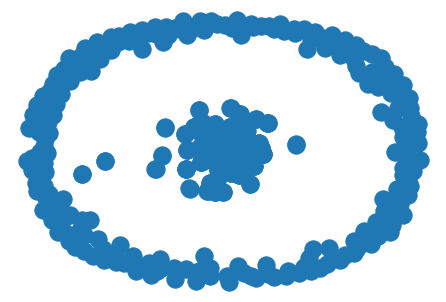

In [61]:
import matplotlib.pyplot as plt

G_Align=nx.Graph()
elist = unique_xmap
G_Align.add_weighted_edges_from(elist)
nx.draw(G_Align)
plt.show()

## compare node and edge connectivity
## compute largest connected component

In [62]:
print('Aligned graph have ',G_Align.number_of_nodes(),' nodes.')
print('Aligned graph have ',G_Align.number_of_edges(),' edges.')

Aligned graph have  623  nodes.
Aligned graph have  1411  edges.


In [63]:
print('Target graph have ',G_target_na.number_of_nodes(),' nodes.')
print('Target graph have ',G_target_na.number_of_edges(), ' edges.')

Target graph have  623  nodes.
Target graph have  1760  edges.


In [64]:
sum_weight=0
for i in range(len(unique_xmap)):
    sum_weight=sum_weight+ unique_xmap[i][2]
total_weight=0    
for i in range(len(nd1)):
    for j in range(len(nd2)):
        temp=G_target_na.get_edge_data(str(nd1[i]),str(nd2[j]))
        if(temp!=None):
            total_weight=total_weight+int(list(temp.values())[0])
print('Maximum Weight in Aligned graph: ',sum_weight) 
print('Total Weight in Target: ',total_weight)

Maximum Weight in Aligned graph:  994225
Total Weight in Target:  1084644


In [65]:
# returns number of different connected components 
print('number of different connected components in Aligned graph: ',nx.number_connected_components(G_Align)) 
print('number of different connected components in Target graph: ',nx.number_connected_components(G_target_na))  

number of different connected components in Aligned graph:  288
number of different connected components in Target graph:  288


In [66]:
# returns list of nodes in different connected components 
cc_align=list(nx.connected_components(G_Align))
cc_target=list(nx.connected_components(G_target_na))
print(list(nx.connected_components(G_Align))) 
print(list(nx.connected_components(G_target_na)))

[{'mm1054', 'mm609', 'mm2332', 'mm6967', 'mm638', 'mm2150', 'mm2070', 'mm1036'}, {'mm8295', 'mm17223', 'mm1150', 'mm1837', 'mm14749', 'mm12658', 'mm2398', 'mm9669', 'mm3362', 'mm8699', 'mm1225', 'mm14981', 'mm19306', 'mm1082', 'mm6584', 'mm2413', 'mm11476', 'mm11480', 'mm1295', 'mm1472', 'mm7887', 'mm2123', 'mm19080', 'mm1092', 'mm5688', 'mm343', 'mm14492', 'mm11761', 'mm14346', 'mm4294', 'mm2263', 'mm1105', 'mm3367', 'mm6309', 'mm126', 'mm3698', 'mm1612', 'mm8967', 'mm3741', 'mm6411', 'mm5807', 'mm2956', 'mm2317', 'mm5042', 'mm2153', 'mm2301', 'mm6435', 'mm5397', 'mm3405', 'mm2388', 'mm5678', 'mm407', 'mm11243', 'mm15570', 'mm231', 'mm1598', 'mm17882', 'mm5138', 'mm3314', 'mm5518', 'mm2827', 'mm6126', 'mm2545', 'mm13841', 'mm6465', 'mm11666', 'mm1226', 'mm831', 'mm5486', 'mm4064', 'mm5183', 'mm5422', 'mm2880', 'mm3398', 'mm377', 'mm6369', 'mm657', 'mm5726', 'mm3872', 'mm5831', 'mm2709', 'mm2454', 'mm1377', 'mm7826', 'mm6851', 'mm20845', 'mm32', 'mm17438', 'mm271', 'mm603', 'mm45', 'mm

In [67]:
# returns number of nodes to be removed 
# so that Graph becomes disconnected 
print(nx.node_connectivity(G_Align)) 
print(nx.node_connectivity(G_target_na))
# returns number of edges to be removed 
# so that Graph becomes disconnected 
print(nx.edge_connectivity(G_Align))
print(nx.edge_connectivity(G_target_na))

0
0
0
0


## check similarity of connected components

In [68]:
count=0
for i in range(len(cc_align)):
    for j in range(len(cc_target)):
        if(cc_align[i]==cc_target[j]):
            count=count+1
print(count)

288


In [70]:
Gc = max(nx.connected_components(G_Align), key=len)
print('Largest common connected graph in Aligned graph: ',len(Gc))
Gct = max(nx.connected_components(G_target_na), key=len)
print('Largest common connected graph in Target graph: ',len(Gct))

Largest common connected graph in Aligned graph:  155
Largest common connected graph in Target graph:  155


### check for mistake align

In [71]:
for i in range(len(unique_xmap)):
    if (G_target_na.has_edge(unique_xmap[i][0], unique_xmap[i][1])==False):
        print(unique_xmap[i])
        print(i)
print('no exist error')    

no exist error


# draw graphs

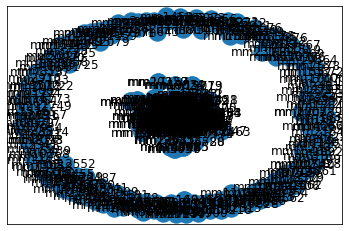

In [72]:
nx.draw_networkx(G1, with_labels = True)

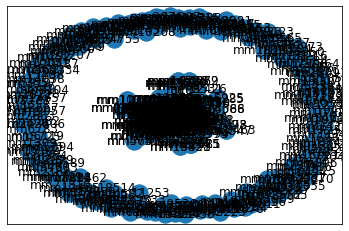

In [73]:
nx.draw_networkx(G2)

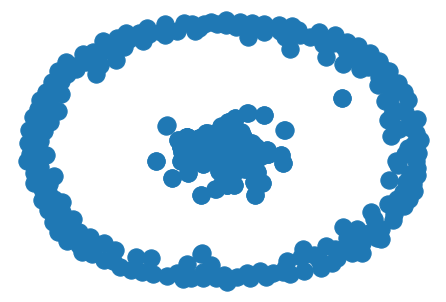

In [74]:
import matplotlib.pyplot as plt
nx.draw(G_target_na)
plt.show()

In [75]:
# total ec
total_ec=G_target_na.number_of_edges()/G1.number_of_edges()*100
ratio_ec=score_ec_temp/total_ec*100
print("total EC: ",total_ec)
print("ratio EC: ",ratio_ec)

total EC:  100.0
ratio EC:  107.04545454545456


In [76]:
# total ics
total_ics=G_target_na.number_of_edges()/count_induced*100
ratio_ics=score_ics_temp/total_ics*100
print("total ICS: ",total_ics)
print("ratio ICS: ",ratio_ics)

total ICS:  100.0
ratio ICS:  107.04545454545456


In [77]:
# total s3
total_s3=(G_target_na.number_of_edges()/(G1.number_of_edges()+count_induced-G_target_na.number_of_edges()))*100
ratio_s3=score_s3_temp/total_s3*100
print("total S3: ",total_s3)
print("ratio S3: ",ratio_s3)

total S3:  100.0
ratio S3:  115.15892420537897


# compute FC

In [2]:
import pickle
with open('mm-mm-weightGraph-SA-GA.pickle', 'rb') as f:
    unique_xmap = pickle.load(f)

In [78]:
tree=[[unique_xmap[i][0],unique_xmap[i][1]] for i in range(len(unique_xmap))]
tree

[['mm2070', 'mm6967'],
 ['mm6564', 'mm6435'],
 ['mm2123', 'mm6564'],
 ['mm5610', 'mm6350'],
 ['mm1612', 'mm1612'],
 ['mm3356', 'mm12511'],
 ['mm303', 'mm2880'],
 ['mm7654', 'mm8758'],
 ['mm5613', 'mm8183'],
 ['mm1150', 'mm11666'],
 ['mm2398', 'mm271'],
 ['mm8390', 'mm9309'],
 ['mm5422', 'mm115'],
 ['mm6851', 'mm6584'],
 ['mm1452', 'mm1452'],
 ['mm20021', 'mm20021'],
 ['mm16941', 'mm14816'],
 ['mm19080', 'mm115'],
 ['mm3195', 'mm8533'],
 ['mm9122', 'mm9122'],
 ['mm6465', 'mm1012'],
 ['mm2709', 'mm1877'],
 ['mm8295', 'mm343'],
 ['mm9869', 'mm6469'],
 ['mm14580', 'mm14580'],
 ['mm3732', 'mm3732'],
 ['mm1598', 'mm1598'],
 ['mm1993', 'mm1837'],
 ['mm2596', 'mm7617'],
 ['mm21409', 'mm4991'],
 ['mm230', 'mm1596'],
 ['mm8252', 'mm8177'],
 ['mm16876', 'mm3866'],
 ['mm4668', 'mm3290'],
 ['mm603', 'mm1051'],
 ['mm3657', 'mm3657'],
 ['mm16458', 'mm15821'],
 ['mm18741', 'mm18741'],
 ['mm20021', 'mm19603'],
 ['mm5042', 'mm9669'],
 ['mm6350', 'mm8780'],
 ['mm45', 'mm32'],
 ['mm166', 'mm3630'],
 ['mm1

# load ontology and create DAG graph

In [79]:
import pandas as pd
f=open('go.dag.obo.txt').readlines()
df=pd.DataFrame(f)
df

,0
0,GO:0046431 GO:0019599\n
1,GO:0046430 GO:0019595\n
2,GO:0046432 GO:0019361\n
3,GO:0034198 GO:0060733\n
4,GO:0046343 GO:0019872\n
...,...
11309,GO:0019194 GO:0022871\n
11310,GO:0019198 GO:0005001\n
11311,GO:0019199 GO:0004675 GO:0004714 GO:0009784\n
11312,GO:0070255 GO:0070256 GO:0070257\n


In [80]:
# preprocessing
dag_list=[]
for i in range(len(df[0])):
    m1=str(df[0][i])
    m1=m1.replace('GO:','')
    m1=m1.replace('\n','')
    s=m1.split(' ')
    dag_list.append(s)
dag_list

[['0046431', '0019599'],
 ['0046430', '0019595'],
 ['0046432', '0019361'],
 ['0034198', '0060733'],
 ['0046343', '0019872'],
 ['0034193', '0034195'],
 ['0034192', '0034194'],
 ['0034190', '0034191'],
 ['0046437', '0030632', '0070179'],
 ['0046340', '0046342'],
 ['0030852', '0045658', '0030853', '0045643', '0030854', '0045640'],
 ['0030853', '0045659', '0045644', '0045641'],
 ['0030851', '0030221', '0030223', '0030222'],
 ['0030856',
  '0003339',
  '0030860',
  '0045601',
  '0030857',
  '0072182',
  '0030858',
  '0045616'],
 ['0030857', '0045602', '0030861', '0045617', '0072183'],
 ['0030854', '0045645', '0045642', '0045660'],
 ['0030855',
  '0030859',
  '0030216',
  '0072192',
  '0060671',
  '0072160',
  '0060742',
  '0035026',
  '0072311',
  '0060487',
  '0045446',
  '0060644',
  '0002065'],
 ['0030858', '0045603', '0030862', '0045618'],
 ['0030859', '0045198'],
 ['0031106', '0032186'],
 ['0031105', '0032151', '0032152'],
 ['0031103', '0014814', '0048673', '0014012'],
 ['0031102', '00

In [81]:
dag_nd=[]
for i in range(len(dag_list)):
    for j in range(len(dag_list[i])):
        dag_nd.append(dag_list[i][j])
dag_nodes=set(dag_nd)
print(dag_nodes)
print(len(dag_nodes))

{'0001716', '0051085', '0042400', '0009385', '0008216', '0070176', '0019747', '0002076', '0032598', '0001846', '0030369', '0032941', '0072192', '0010018', '0010601', '0047303', '0050085', '0048440', '0042533', '0060439', '0030077', '0032697', '0031896', '0002903', '0072126', '0044041', '0042223', '0033108', '0009331', '0045263', '0008284', '0006117', '0021956', '0015760', '0061036', '0048086', '0019761', '0006523', '0032371', '0051307', '0047223', '0032415', '0004800', '0045698', '0016499', '0051282', '0014060', '0060388', '0071032', '0006846', '0047433', '0072273', '0042577', '0075016', '0048596', '0070266', '0048167', '0004550', '0032678', '0071124', '0010312', '0035141', '0044178', '0016813', '0046680', '0072169', '0034952', '0002239', '0046157', '0031283', '0018219', '0002736', '0060036', '0046250', '0021601', '0072152', '0042887', '0052094', '0050674', '0047414', '0052443', '0034150', '0051917', '0032935', '0002581', '0001812', '0004517', '0042672', '0047892', '0032364', '0090010'

In [82]:
# create dag edges
dag_edges=[]
for i in range(len(dag_list)):
    for j in range(1,len(dag_list[i])):
        ed=[dag_list[i][0],dag_list[i][j]]
        dag_edges.append(ed)
dag_edges

[['0046431', '0019599'],
 ['0046430', '0019595'],
 ['0046432', '0019361'],
 ['0034198', '0060733'],
 ['0046343', '0019872'],
 ['0034193', '0034195'],
 ['0034192', '0034194'],
 ['0034190', '0034191'],
 ['0046437', '0030632'],
 ['0046437', '0070179'],
 ['0046340', '0046342'],
 ['0030852', '0045658'],
 ['0030852', '0030853'],
 ['0030852', '0045643'],
 ['0030852', '0030854'],
 ['0030852', '0045640'],
 ['0030853', '0045659'],
 ['0030853', '0045644'],
 ['0030853', '0045641'],
 ['0030851', '0030221'],
 ['0030851', '0030223'],
 ['0030851', '0030222'],
 ['0030856', '0003339'],
 ['0030856', '0030860'],
 ['0030856', '0045601'],
 ['0030856', '0030857'],
 ['0030856', '0072182'],
 ['0030856', '0030858'],
 ['0030856', '0045616'],
 ['0030857', '0045602'],
 ['0030857', '0030861'],
 ['0030857', '0045617'],
 ['0030857', '0072183'],
 ['0030854', '0045645'],
 ['0030854', '0045642'],
 ['0030854', '0045660'],
 ['0030855', '0030859'],
 ['0030855', '0030216'],
 ['0030855', '0072192'],
 ['0030855', '0060671'],


In [83]:
import networkx as nx
go=nx.DiGraph()
go.add_nodes_from(dag_nodes)
go.add_edges_from(dag_edges)
go

In [84]:
c=0
import numpy as np
na=tree
for i in range(len(tree)):
    for j in range(2):
        if ('mm' in tree[i][j] or 'sc' in tree[i][j]):
            s=tree[i][j][2:]
            x='0'*(7-len(s))
            y=x+s
            #print(y)
            na[i][j]=y
            c=c+1
print(len(tree),c)
print(len(na))

1884 3768
1884


In [85]:
fc=[]
for i in range(len(na)):
    if na[i][0] in dag_nodes:
        e=go.predecessors(na[i][0])
        if na[i][1] in dag_nodes: 
            f=go.predecessors(na[i][1])
            temp=[]
            for key in e:
                temp.append(key)
            for key in f:
                temp.append(key)
            # compute intersection/union 
            fc.append(sum([temp.count(temp[z])/len(temp) for z in range(len(temp))]))
        else:
            fc.append(0)
#print(fc)
# compute average of all fc 
func=np.average(fc)
print('functional coherence:',func)

functional coherence: 1.1157446808510638
